In [27]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [28]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(image_current.shape)
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)    

    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow


def crop_image(image, scale):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (66, 220, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (66, 220, 3) if not done so already from perspective transform
    """
    # Crop out sky (top 130px) and the hood of the car (bottom 270px) 
    image_cropped = image[130:370,:] # -> (240, 640, 3)
    
    height = int(240*scale)
    width = int(640*scale)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

def preprocess_image_valid_from_path(image_path, scale_factor=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image(img, scale_factor)
    return img

In [29]:
test_data = pd.read_csv('/srv/beegfs02/scratch/aegis_guardian/data/speed_prediction/deeps/valid_data.csv')
test_data = test_data[['image_path', 'time', 'speed']]

In [35]:
test_data

image_path         time  \
0      /srv/beegfs02/scratch/aegis_guardian/data/data...  3355.583333   
1      /srv/beegfs02/scratch/aegis_guardian/data/data...  3355.666667   
2      /srv/beegfs02/scratch/aegis_guardian/data/data...  2945.583333   
3      /srv/beegfs02/scratch/aegis_guardian/data/data...  2945.666667   
4      /srv/beegfs02/scratch/aegis_guardian/data/data...   857.000000   
...                                                  ...          ...   
20209  /srv/beegfs02/scratch/aegis_guardian/data/data...  3553.166667   
20210  /srv/beegfs02/scratch/aegis_guardian/data/data...  2570.833333   
20211  /srv/beegfs02/scratch/aegis_guardian/data/data...  2570.916667   
20212  /srv/beegfs02/scratch/aegis_guardian/data/data...  4109.583333   
20213  /srv/beegfs02/scratch/aegis_guardian/data/data...  4109.666667   

          speed  
0      0.292385  
1      0.291508  
2      0.464362  
3      0.467332  
4      0.347915  
...         ...  
20209  0.000000  
20210  0.383489  
20211  0.383492  
20212  0.638516  
20213  0.637674  

[20214 rows x 3 columns]

In [30]:
i=0
while i < len(test_data):
    speed1 = test_data.iloc[i]['speed']
    speed2 = test_data.iloc[i+1]['speed']

    img1 = preprocess_image_valid_from_path(test_data.iloc[i]['image_path'],scale_factor)
    img2 = preprocess_image_valid_from_path(test_data.iloc[i+1]['image_path'],scale_factor)

    rgb_diff = opticalFlowDense(img1, img2)
    rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
    avg_speed = np.array([[np.mean([speed1,speed2])]])

    i1 = test_data.iloc[i]['image_path']
    i2 = test_data.iloc[i+1]['image_path']
    
#     prediction = model.predict(rgb_diff)
#     predict_speed.append(float(prediction[0]))
#     labels.append(avg_speed)
    
    print('------------------------------------------------------------------------------------------')
    print(f'\nImage {i}: {i1}')
    print(f'Image {i+1}: {i2}')
    print(f'Image 1 processed: {np.average(img1)}')
    print(f'Image 2 processed: {np.average(img2)}')
    print(f'Optical flow avg: {np.average(rgb_diff)}')
#     print(f'Truth: {avg_speed} Prediction: {prediction[0][0]}')
    print('------------------------------------------------------------------------------------------')
    i+=2

------------------------------------------------------------------------------------------

Image 0: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3355.5833333349665.jpg
Image 1: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3355.6666666683.jpg
Image 1 processed: 187.96154729109276
Image 2 processed: 191.83845270890725
Optical flow avg: -317.4491882324219
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2945.5833333342207.jpg
Image 3: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hamm

------------------------------------------------------------------------------------------

Image 30: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1630.1666666663016.jpg
Image 31: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1630.2499999996348.jpg
Image 1 processed: 154.28041781450872
Image 2 processed: 154.6895546372819
Optical flow avg: -1047.9078369140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 32: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1662.9166666662718.jpg
Image 33: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/traini

Image 1 processed: 103.6239898989899
Image 2 processed: 103.88250688705234
Optical flow avg: -1048.5330810546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 62: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2486.3333333333853.jpg
Image 63: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2486.416666666719.jpg
Image 1 processed: 120.70431588613407
Image 2 processed: 181.78252984389349
Optical flow avg: -299.0155334472656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 64: /srv/beegfs02/scratch/aegis_guardian/data/d

------------------------------------------------------------------------------------------

Image 92: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/219.83333333334085.jpg
Image 93: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/219.9166666666742.jpg
Image 1 processed: 80.74136822773187
Image 2 processed: 81.37474747474748
Optical flow avg: -5265.94873046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 94: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4125.750000002871.jpg
Image 95: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Ha

------------------------------------------------------------------------------------------

Image 124: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2133.333333332743.jpg
Image 125: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2133.4166666660767.jpg
Image 1 processed: 143.45530303030304
Image 2 processed: 148.37245179063362
Optical flow avg: -2233.0283203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 126: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/12.08333333333335.jpg
Image 127: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/traini

------------------------------------------------------------------------------------------

Image 156: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1319.9166666665838.jpg
Image 157: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1319.999999999917.jpg
Image 1 processed: 199.15431588613407
Image 2 processed: 199.1151974288338
Optical flow avg: -108.68274688720703
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1083.0000000001326.jpg
Image 159: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 188: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4065.8333333362584.jpg
Image 189: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4065.916666669592.jpg
Image 1 processed: 161.18661616161617
Image 2 processed: 104.47050045913683
Optical flow avg: -1658.826416015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2065.6666666659535.jpg
Image 191: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1197.5833333333617.jpg
Image 221: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1197.666666666695.jpg
Image 1 processed: 152.49566115702478
Image 2 processed: 155.2055785123967
Optical flow avg: -1519.83349609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 222: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2323.916666666423.jpg
Image 223: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/traini

------------------------------------------------------------------------------------------

Image 252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2883.3333333341075.jpg
Image 253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2883.416666667441.jpg
Image 1 processed: 174.18617998163452
Image 2 processed: 174.44497245179065
Optical flow avg: -110.951904296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2966.1666666675915.jpg
Image 255: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 282: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1234.6666666666613.jpg
Image 283: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1234.7499999999945.jpg
Image 1 processed: 140.62807621671257
Image 2 processed: 140.59855371900827
Optical flow avg: -160.67140197753906
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 284: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2667.250000000381.jpg
Image 285: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 314: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3410.0833333350656.jpg
Image 315: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3410.166666668399.jpg
Image 1 processed: 189.09334251606978
Image 2 processed: 190.73666207529843
Optical flow avg: -911.4429931640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 316: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/674.0833333333604.jpg
Image 317: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 346: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/25.91666666666657.jpg
Image 347: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/25.9999999999999.jpg
Image 1 processed: 138.76338383838385
Image 2 processed: 136.6616850321396
Optical flow avg: -1542.9364013671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/160.33333333333408.jpg
Image 349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2840.500000000696.jpg
Image 375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2840.5833333340297.jpg
Image 1 processed: 166.89093204775023
Image 2 processed: 165.95204315886133
Optical flow avg: -368.8899841308594
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/185.83333333333698.jpg
Image 377: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 406: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3541.416666668638.jpg
Image 407: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3541.5000000019713.jpg
Image 1 processed: 171.9946051423324
Image 2 processed: 172.2424012855831
Optical flow avg: -510.9274597167969
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 408: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3295.16666666819.jpg
Image 409: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trainin

------------------------------------------------------------------------------------------

Image 434: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3709.0833333356095.jpg
Image 435: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3709.166666668943.jpg
Image 1 processed: 145.55415518824609
Image 2 processed: 145.37325528007347
Optical flow avg: -2649.37353515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 436: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1755.7499999995207.jpg
Image 437: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1792.6666666661538.jpg
Image 467: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1792.749999999487.jpg
Image 1 processed: 188.07304866850322
Image 2 processed: 186.4853994490358
Optical flow avg: -294.10211181640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 468: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2986.916666667629.jpg
Image 469: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 498: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/51.25000000000036.jpg
Image 499: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/51.3333333333337.jpg
Image 1 processed: 98.97164830119375
Image 2 processed: 130.26985766758494
Optical flow avg: -1199.7821044921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/407.49999999997715.jpg
Image 501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2300.16666666638.jpg
Image 531: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2300.2499999997135.jpg
Image 1 processed: 155.22456382001837
Image 2 processed: 144.83753443526172
Optical flow avg: -1229.8194580078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 532: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3207.000000001363.jpg
Image 533: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 560: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2091.8333333326677.jpg
Image 561: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2091.916666666001.jpg
Image 1 processed: 153.91078971533517
Image 2 processed: 108.68698347107438
Optical flow avg: -1274.461669921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 562: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2378.666666666523.jpg
Image 563: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 592: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1123.3333333334292.jpg
Image 593: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1123.4166666667625.jpg
Image 1 processed: 139.5709595959596
Image 2 processed: 138.72095959595958
Optical flow avg: -2875.677978515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 594: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/441.9999999999693.jpg
Image 595: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 624: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/432.2499999999715.jpg
Image 625: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/432.33333333330484.jpg
Image 1 processed: 113.61278696051423
Image 2 processed: 120.01292470156106
Optical flow avg: -3046.684326171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 626: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3322.0833333349055.jpg
Image 627: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1465.6666666664512.jpg
Image 657: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1465.7499999997844.jpg
Image 1 processed: 155.53969237832874
Image 2 processed: 158.56602387511478
Optical flow avg: -1382.001708984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 658: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1434.4166666664796.jpg
Image 659: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/878.9166666667869.jpg
Image 685: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/879.0000000001203.jpg
Image 1 processed: 121.78197887970616
Image 2 processed: 122.43041781450873
Optical flow avg: -376.9626159667969
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 686: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1499.4166666664205.jpg
Image 687: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 716: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1228.416666666667.jpg
Image 717: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1228.5000000000002.jpg
Image 1 processed: 140.69380165289257
Image 2 processed: 140.7587924701561
Optical flow avg: -320.1061096191406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 718: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2286.6666666663555.jpg
Image 719: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 748: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3905.583333335967.jpg
Image 749: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3905.6666666693004.jpg
Image 1 processed: 175.58636363636364
Image 2 processed: 172.04717630853995
Optical flow avg: -1728.1129150390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 750: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/590.249999999989.jpg
Image 751: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 780: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1703.5833333329015.jpg
Image 781: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1703.6666666662347.jpg
Image 1 processed: 166.9053489439853
Image 2 processed: 167.22027089072543
Optical flow avg: -2078.759033203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/322.24999999999653.jpg
Image 783: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 812: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1141.2500000000796.jpg
Image 813: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1141.3333333334128.jpg
Image 1 processed: 151.84297520661158
Image 2 processed: 151.88335629017448
Optical flow avg: -362.8639221191406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/930.0000000001435.jpg
Image 815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 844: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2971.5000000009345.jpg
Image 845: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2971.583333334268.jpg
Image 1 processed: 161.9990358126722
Image 2 processed: 152.27093663911845
Optical flow avg: -863.216064453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3413.250000001738.jpg
Image 847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/traini

------------------------------------------------------------------------------------------

Image 876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4015.6666666695005.jpg
Image 877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4015.750000002834.jpg
Image 1 processed: 207.4770202020202
Image 2 processed: 205.16873278236915
Optical flow avg: -238.86602783203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 878: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/16.916666666666696.jpg
Image 879: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 908: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1377.3333333331982.jpg
Image 909: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1377.4166666665315.jpg
Image 1 processed: 192.2216712580349
Image 2 processed: 219.2272497704316
Optical flow avg: -34.77132797241211
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 910: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2541.083333333485.jpg
Image 911: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 940: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1113.7500000001046.jpg
Image 941: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1113.8333333334378.jpg
Image 1 processed: 152.51108815426997
Image 2 processed: 153.91007805325987
Optical flow avg: -685.258544921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 942: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/858.8333333334444.jpg
Image 943: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 966: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3309.75000000155.jpg
Image 967: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3309.8333333348833.jpg
Image 1 processed: 169.40752984389349
Image 2 processed: 165.89935720844812
Optical flow avg: -938.929931640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 968: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3422.2500000017544.jpg
Image 969: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 994: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3328.7500000015843.jpg
Image 995: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3328.833333334918.jpg
Image 1 processed: 208.975
Image 2 processed: 210.6407483930211
Optical flow avg: -286.7828063964844
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 996: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3381.3333333350133.jpg
Image 997: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammon

------------------------------------------------------------------------------------------

Image 1022: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1225.0000000000034.jpg
Image 1023: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1225.0833333333367.jpg
Image 1 processed: 140.8431129476584
Image 2 processed: 140.84063360881544
Optical flow avg: -139.60069274902344
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2857.166666667393.jpg
Image 1025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 1050: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2790.5000000006053.jpg
Image 1051: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2790.5833333339388.jpg
Image 1 processed: 136.1744031221304
Image 2 processed: 138.7193526170799
Optical flow avg: -625.9483642578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1052: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3405.666666668391.jpg
Image 1053: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 1076: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3039.0833333343908.jpg
Image 1077: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3039.1666666677243.jpg
Image 1 processed: 116.78335629017447
Image 2 processed: 146.08785583103764
Optical flow avg: -1249.23828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/110.49999999999808.jpg
Image 1079: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 1102: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1941.0833333326855.jpg
Image 1103: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1941.1666666660187.jpg
Image 1 processed: 146.7134756657484
Image 2 processed: 144.3196510560147
Optical flow avg: -179.81103515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1104: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/182.25000000000324.jpg
Image 1105: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 1128: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/103.99999999999845.jpg
Image 1129: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/104.08333333333178.jpg
Image 1 processed: 170.47637741046833
Image 2 processed: 92.5349173553719
Optical flow avg: -1774.75244140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1130: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3956.7500000027267.jpg
Image 1131: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 1156: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1138.2500000000823.jpg
Image 1157: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1138.3333333334156.jpg
Image 1 processed: 128.43310376492195
Image 2 processed: 151.94088613406797
Optical flow avg: -1506.1910400390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4099.500000002967.jpg
Image 1159: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 1186: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3353.75000000163.jpg
Image 1187: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3353.8333333349633.jpg
Image 1 processed: 180.03950872359962
Image 2 processed: 178.79616620752984
Optical flow avg: -1446.3275146484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1188: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3404.2500000017217.jpg
Image 1189: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 1214: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2182.3333333328324.jpg
Image 1215: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2182.416666666166.jpg
Image 1 processed: 141.12116620752985
Image 2 processed: 139.33969237832875
Optical flow avg: -785.7793579101562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1216: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2287.999999999691.jpg
Image 1217: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1240: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/705.6666666667081.jpg
Image 1241: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/705.7500000000415.jpg
Image 1 processed: 94.15020661157025
Image 2 processed: 88.81990358126721
Optical flow avg: -2603.668701171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1242: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3168.833333334627.jpg
Image 1243: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 1266: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2649.0833333336814.jpg
Image 1267: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2649.166666667015.jpg
Image 1 processed: 171.33774104683195
Image 2 processed: 169.52699724517907
Optical flow avg: -510.3310241699219
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1268: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/510.08333333328716.jpg
Image 1269: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 1294: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2900.250000000805.jpg
Image 1295: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2900.3333333341384.jpg
Image 1 processed: 178.72210743801654
Image 2 processed: 187.303145087236
Optical flow avg: -749.9080810546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1296: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1213.0000000000143.jpg
Image 1297: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 1322: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/407.1666666666439.jpg
Image 1323: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/407.2499999999772.jpg
Image 1 processed: 140.47860422405876
Image 2 processed: 140.18007346189165
Optical flow avg: -2433.2861328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1324: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2791.5833333339406.jpg
Image 1325: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 1348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1071.500000000143.jpg
Image 1349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1071.5833333334763.jpg
Image 1 processed: 102.72768595041322
Image 2 processed: 139.32830578512397
Optical flow avg: -2346.150146484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1350: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3910.583333335976.jpg
Image 1351: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1566.583333333026.jpg
Image 1377: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1566.6666666663593.jpg
Image 1 processed: 175.75459136822772
Image 2 processed: 173.00121671258034
Optical flow avg: -731.4177856445312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1378: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3187.250000001327.jpg
Image 1379: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1404: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2497.6666666667393.jpg
Image 1405: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2497.7500000000728.jpg
Image 1 processed: 196.53264462809918
Image 2 processed: 196.62752525252526
Optical flow avg: -134.4877471923828
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1406: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/274.75000000000733.jpg
Image 1407: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 1432: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/527.5833333332938.jpg
Image 1433: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/527.6666666666272.jpg
Image 1 processed: 138.54152892561984
Image 2 processed: 138.33666207529845
Optical flow avg: -2854.46435546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1434: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/677.1666666666952.jpg
Image 1435: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 1460: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/784.7500000000774.jpg
Image 1461: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/784.8333333334108.jpg
Image 1 processed: 138.46280991735537
Image 2 processed: 138.65199724517907
Optical flow avg: -714.2705688476562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1462: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/964.250000000159.jpg
Image 1463: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 1488: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/578.6666666666504.jpg
Image 1489: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/578.7499999999837.jpg
Image 1 processed: 113.11400367309459
Image 2 processed: 113.94084022038568
Optical flow avg: -818.2537231445312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2110.4999999993684.jpg
Image 1491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1514: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3723.5000000023024.jpg
Image 1515: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3723.583333335636.jpg
Image 1 processed: 129.86691919191918
Image 2 processed: 124.60174471992654
Optical flow avg: -1622.0379638671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1516: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/623.3333333333374.jpg
Image 1517: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 1542: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3338.333333334935.jpg
Image 1543: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3338.4166666682686.jpg
Image 1 processed: 199.50075757575758
Image 2 processed: 199.87819100091826
Optical flow avg: -732.4315185546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1551.2499999997067.jpg
Image 1545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 1572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/258.3333333333444.jpg
Image 1573: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/258.4166666666777.jpg
Image 1 processed: 123.23161157024794
Image 2 processed: 123.21065197428834
Optical flow avg: -1047.843017578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1884.8333333327366.jpg
Image 1575: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/393.9999999999802.jpg
Image 1601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/394.08333333331353.jpg
Image 1 processed: 149.17479338842975
Image 2 processed: 148.57364554637283
Optical flow avg: -2205.21533203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3812.416666669131.jpg
Image 1603: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 1628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2565.000000000195.jpg
Image 1629: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2565.0833333335286.jpg
Image 1 processed: 70.11157024793388
Image 2 processed: 108.73353994490358
Optical flow avg: -1794.9071044921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1288.916666666612.jpg
Image 1631: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/43.91666666666682.jpg
Image 1655: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/44.000000000000156.jpg
Image 1 processed: 128.7429292929293
Image 2 processed: 128.18358585858587
Optical flow avg: -1375.490966796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3150.50000000126.jpg
Image 1657: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 1680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2301.5833333330493.jpg
Image 1681: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2301.6666666663828.jpg
Image 1 processed: 132.72855831037648
Image 2 processed: 132.28314967860422
Optical flow avg: -439.3199768066406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1847.8333333327703.jpg
Image 1683: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 1708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/993.5833333335057.jpg
Image 1709: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/993.6666666668391.jpg
Image 1 processed: 125.9407943067034
Image 2 processed: 127.74253902662994
Optical flow avg: -358.3753662109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1308.2499999999277.jpg
Image 1711: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 1736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2032.9166666659353.jpg
Image 1737: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2032.9999999992685.jpg
Image 1 processed: 197.47929292929294
Image 2 processed: 197.2558769513315
Optical flow avg: -108.29125213623047
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3462.916666668495.jpg
Image 1739: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 1764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2078.7499999993106.jpg
Image 1765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2078.833333332644.jpg
Image 1 processed: 199.52151056014694
Image 2 processed: 198.50670339761248
Optical flow avg: -134.90550231933594
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3297.8333333348614.jpg
Image 1767: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 1792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2057.833333332606.jpg
Image 1793: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2057.9166666659394.jpg
Image 1 processed: 195.37722681359045
Image 2 processed: 196.27467860422405
Optical flow avg: -125.4498519897461
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/611.9999999999989.jpg
Image 1795: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1818: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2691.9166666670926.jpg
Image 1819: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2692.000000000426.jpg
Image 1 processed: 59.743640955004594
Image 2 processed: 162.98140495867767
Optical flow avg: -633.6594848632812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3400.833333335049.jpg
Image 1821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/174.08333333333564.jpg
Image 1847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/174.166666666669.jpg
Image 1 processed: 103.90619834710743
Image 2 processed: 104.26363636363637
Optical flow avg: -1959.94873046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2221.6666666662372.jpg
Image 1849: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 1876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3473.416666668514.jpg
Image 1877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3473.5000000018476.jpg
Image 1 processed: 136.09414600550963
Image 2 processed: 116.06352157943067
Optical flow avg: -1098.67578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1878: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/337.5833333333264.jpg
Image 1879: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 1904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4085.7500000029613.jpg
Image 1905: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4085.833333336295.jpg
Image 1 processed: 132.46648301193756
Image 2 processed: 130.2709595959596
Optical flow avg: -1912.835205078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1906: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2248.1666666662854.jpg
Image 1907: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 1930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/179.8333333333363.jpg
Image 1931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/179.91666666666964.jpg
Image 1 processed: 177.92307162534436
Image 2 processed: 101.26030762167126
Optical flow avg: -937.0533447265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1570.4999999996892.jpg
Image 1933: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 1960: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4057.2500000029095.jpg
Image 1961: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4057.333333336243.jpg
Image 1 processed: 84.37842056932966
Image 2 processed: 81.11363636363636
Optical flow avg: -2792.831298828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1962: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3918.833333335991.jpg
Image 1963: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 1986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2689.916666667089.jpg
Image 1987: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2690.0000000004225.jpg
Image 1 processed: 169.8504132231405
Image 2 processed: 167.9385904499541
Optical flow avg: -1259.15966796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 1988: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1939.7499999993533.jpg
Image 1989: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 2012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1422.8333333331568.jpg
Image 2013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1422.91666666649.jpg
Image 1 processed: 140.09855371900827
Image 2 processed: 138.22382920110192
Optical flow avg: -2953.4541015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1219.0833333333421.jpg
Image 2015: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 2038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1404.4999999998402.jpg
Image 2039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1404.5833333331734.jpg
Image 1 processed: 199.5581955922865
Image 2 processed: 199.5469008264463
Optical flow avg: -19.937841415405273
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1529.9166666663928.jpg
Image 2041: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 2066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/808.5833333334216.jpg
Image 2067: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/808.666666666755.jpg
Image 1 processed: 129.21356749311295
Image 2 processed: 184.62011019283747
Optical flow avg: -145.01931762695312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2068: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4048.8333333362275.jpg
Image 2069: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 2094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2546.0000000001605.jpg
Image 2095: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2546.083333333494.jpg
Image 1 processed: 103.66531221303948
Image 2 processed: 103.5426997245179
Optical flow avg: -1032.612060546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2096: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3678.25000000222.jpg
Image 2097: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 2122: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3653.333333335508.jpg
Image 2123: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3653.4166666688416.jpg
Image 1 processed: 159.58792470156106
Image 2 processed: 165.75775941230486
Optical flow avg: -376.23175048828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2124: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1264.5833333333007.jpg
Image 2125: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 2150: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2638.916666666996.jpg
Image 2151: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2639.0000000003297.jpg
Image 1 processed: 175.44706152433426
Image 2 processed: 174.86565656565656
Optical flow avg: -295.359619140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2152: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1816.666666666132.jpg
Image 2153: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 2178: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/379.4166666666502.jpg
Image 2179: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/379.4999999999835.jpg
Image 1 processed: 143.7980486685032
Image 2 processed: 142.26028466483012
Optical flow avg: -1570.7840576171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2180: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1533.7499999997226.jpg
Image 2181: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 2204: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1295.083333333273.jpg
Image 2205: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1295.1666666666063.jpg
Image 1 processed: 167.40814967860422
Image 2 processed: 170.90814967860422
Optical flow avg: -208.0149688720703
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2206: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/952.0000000001535.jpg
Image 2207: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 2232: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/918.4166666668049.jpg
Image 2233: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/918.5000000001382.jpg
Image 1 processed: 126.97734159779614
Image 2 processed: 127.11905417814509
Optical flow avg: -1098.45947265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2234: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2475.7500000000327.jpg
Image 2235: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 2260: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/251.33333333334443.jpg
Image 2261: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/251.41666666667777.jpg
Image 1 processed: 121.36258034894398
Image 2 processed: 121.3051652892562
Optical flow avg: -3338.226318359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2262: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3583.4166666687142.jpg
Image 2263: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 2288: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4146.250000002797.jpg
Image 2289: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4146.33333333613.jpg
Image 1 processed: 150.07011019283746
Image 2 processed: 150.5626492194674
Optical flow avg: -1310.5047607421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2290: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2426.333333333276.jpg
Image 2291: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 2314: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2459.0000000000023.jpg
Image 2315: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2459.0833333333358.jpg
Image 1 processed: 190.69432966023876
Image 2 processed: 187.27998163452708
Optical flow avg: -472.85382080078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2316: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/464.9999999999641.jpg
Image 2317: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 2342: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4072.7500000029377.jpg
Image 2343: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4072.833333336271.jpg
Image 1 processed: 118.41831955922865
Image 2 processed: 122.37359963269054
Optical flow avg: -2788.008056640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2344: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3321.5833333349046.jpg
Image 2345: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 2368: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/40.750000000000064.jpg
Image 2369: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/40.8333333333334.jpg
Image 1 processed: 107.83927915518825
Image 2 processed: 106.59919651056015
Optical flow avg: -2311.897705078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2370: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2397.416666666557.jpg
Image 2371: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 2396: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2798.166666667286.jpg
Image 2397: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2798.2500000006194.jpg
Image 1 processed: 176.76443985307623
Image 2 processed: 175.19692378328742
Optical flow avg: -359.96014404296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2398: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3076.916666667793.jpg
Image 2399: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 2424: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/476.41666666662815.jpg
Image 2425: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/476.49999999996146.jpg
Image 1 processed: 130.21742424242424
Image 2 processed: 130.5225665748393
Optical flow avg: -1105.0286865234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2426: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3845.8333333358582.jpg
Image 2427: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 2450: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2775.166666667244.jpg
Image 2451: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2775.2500000005775.jpg
Image 1 processed: 60.84428374655647
Image 2 processed: 195.29178145087235
Optical flow avg: -316.0678405761719
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2452: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1094.9166666667884.jpg
Image 2453: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 2476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2711.6666666671285.jpg
Image 2477: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2711.750000000462.jpg
Image 1 processed: 143.53583562901744
Image 2 processed: 145.86678145087237
Optical flow avg: -571.5053100585938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2478: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2321.166666666418.jpg
Image 2479: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 2502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/609.2499999999976.jpg
Image 2503: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/609.333333333331.jpg
Image 1 processed: 135.90899908172636
Image 2 processed: 135.33243801652893
Optical flow avg: -1772.2271728515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2504: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/66.2500000000006.jpg
Image 2505: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 2528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2101.666666666019.jpg
Image 2529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2101.7499999993524.jpg
Image 1 processed: 196.0630624426079
Image 2 processed: 195.4705922865014
Optical flow avg: -120.5487289428711
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/934.5000000001455.jpg
Image 2531: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 2556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2714.3333333338.jpg
Image 2557: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2714.4166666671335.jpg
Image 1 processed: 185.27132690541782
Image 2 processed: 183.0019513314968
Optical flow avg: -574.9468994140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2558: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3449.833333335138.jpg
Image 2559: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 2584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/253.416666666678.jpg
Image 2585: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/253.50000000001134.jpg
Image 1 processed: 123.95883838383838
Image 2 processed: 123.91221303948576
Optical flow avg: -745.7958374023438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2586: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3652.66666666884.jpg
Image 2587: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 2612: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2492.1666666667293.jpg
Image 2613: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2492.2500000000628.jpg
Image 1 processed: 164.8649678604224
Image 2 processed: 166.8293388429752
Optical flow avg: -116.39832305908203
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2614: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1991.2499999993065.jpg
Image 2615: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 2640: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2215.3333333328924.jpg
Image 2641: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2215.416666666226.jpg
Image 1 processed: 197.76292470156108
Image 2 processed: 197.212580348944
Optical flow avg: -75.11630249023438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2642: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1122.5000000000966.jpg
Image 2643: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 2668: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3633.250000002138.jpg
Image 2669: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3633.3333333354717.jpg
Image 1 processed: 163.4109963269054
Image 2 processed: 163.00651974288337
Optical flow avg: -786.7904663085938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2505.666666666754.jpg
Image 2671: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 2696: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3444.000000001794.jpg
Image 2697: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3444.0833333351275.jpg
Image 1 processed: 148.25057392102846
Image 2 processed: 142.1788567493113
Optical flow avg: -1606.6888427734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2698: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/118.83333333333094.jpg
Image 2699: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 2722: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/296.91666666666896.jpg
Image 2723: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/297.0000000000023.jpg
Image 1 processed: 123.13234618916437
Image 2 processed: 123.15291551882461
Optical flow avg: -621.7667846679688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2724: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3985.666666669446.jpg
Image 2725: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 2748: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/466.08333333329716.jpg
Image 2749: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/466.1666666666305.jpg
Image 1 processed: 89.5959595959596
Image 2 processed: 138.28443526170798
Optical flow avg: -1828.89453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2750: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3918.2500000026566.jpg
Image 2751: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 2774: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3079.00000000113.jpg
Image 2775: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3079.0833333344635.jpg
Image 1 processed: 137.9873507805326
Image 2 processed: 146.5874655647383
Optical flow avg: -801.4612426757812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2776: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3224.916666668062.jpg
Image 2777: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 2802: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3245.7500000014334.jpg
Image 2803: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3245.833333334767.jpg
Image 1 processed: 144.8426997245179
Image 2 processed: 147.5775482093664
Optical flow avg: -1229.0494384765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2804: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3796.1666666691012.jpg
Image 2805: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 2830: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1365.0833333332093.jpg
Image 2831: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1365.1666666665426.jpg
Image 1 processed: 114.32998163452709
Image 2 processed: 139.14618916437098
Optical flow avg: -1397.0389404296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2832: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.166666668581.jpg
Image 2833: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 2858: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2755.583333333875.jpg
Image 2859: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2755.6666666672086.jpg
Image 1 processed: 166.33482552800734
Image 2 processed: 167.75959595959597
Optical flow avg: -228.7620086669922
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2860: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1937.9166666660217.jpg
Image 2861: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 2884: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3298.083333334862.jpg
Image 2885: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3298.1666666681954.jpg
Image 1 processed: 149.03535353535352
Image 2 processed: 164.25048209366392
Optical flow avg: -1792.687744140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2886: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3658.16666666885.jpg
Image 2887: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 2912: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/289.7500000000039.jpg
Image 2913: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/289.83333333333724.jpg
Image 1 processed: 121.814072543618
Image 2 processed: 121.82178604224059
Optical flow avg: -155.0977325439453
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2914: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/18.833333333333336.jpg
Image 2915: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 2938: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/818.0000000000925.jpg
Image 2939: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/818.0833333334259.jpg
Image 1 processed: 153.92403581267217
Image 2 processed: 155.51542699724519
Optical flow avg: -933.97802734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2940: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.6666666667459.jpg
Image 2941: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 2966: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4110.58333333626.jpg
Image 2967: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4110.666666669593.jpg
Image 1 processed: 162.11310835629018
Image 2 processed: 162.42102846648302
Optical flow avg: -671.9852294921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2968: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3253.08333333478.jpg
Image 2969: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 2992: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/231.33333333334215.jpg
Image 2993: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/231.4166666666755.jpg
Image 1 processed: 76.1672865013774
Image 2 processed: 77.07603305785123
Optical flow avg: -5780.61767578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 2994: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2406.916666666574.jpg
Image 2995: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 3020: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3727.75000000231.jpg
Image 3021: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3727.8333333356436.jpg
Image 1 processed: 121.29024334251606
Image 2 processed: 121.81483011937557
Optical flow avg: -2019.8641357421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3022: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2980.666666667618.jpg
Image 3023: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3046: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1722.3333333328844.jpg
Image 3047: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1722.4166666662177.jpg
Image 1 processed: 175.04802571166206
Image 2 processed: 140.9086547291093
Optical flow avg: -840.3640747070312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3048: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1820.0833333327955.jpg
Image 3049: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3076: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1916.8333333327075.jpg
Image 3077: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1916.9166666660408.jpg
Image 1 processed: 158.87497704315885
Image 2 processed: 114.08898071625345
Optical flow avg: -2865.942138671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3913.166666669314.jpg
Image 3079: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3102: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2159.8333333327914.jpg
Image 3103: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2159.916666666125.jpg
Image 1 processed: 180.0510560146924
Image 2 processed: 180.11471533516988
Optical flow avg: -906.5829467773438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3104: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2592.7500000002456.jpg
Image 3105: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3130: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/350.9166666666567.jpg
Image 3131: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/350.99999999999.jpg
Image 1 processed: 94.3391873278237
Image 2 processed: 98.0489898989899
Optical flow avg: -3825.451171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3132: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2285.3333333330197.jpg
Image 3133: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/

------------------------------------------------------------------------------------------

Image 3158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1073.3333333334747.jpg
Image 3159: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1073.416666666808.jpg
Image 1 processed: 109.41361340679522
Image 2 processed: 138.8976354453627
Optical flow avg: -2432.521484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3160: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2153.3333333327796.jpg
Image 3161: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 3186: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/89.99999999999925.jpg
Image 3187: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/90.08333333333258.jpg
Image 1 processed: 136.18388429752065
Image 2 processed: 104.38374655647382
Optical flow avg: -1249.58154296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3188: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3230.416666668072.jpg
Image 3189: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 3214: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/941.8333333334822.jpg
Image 3215: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/941.9166666668156.jpg
Image 1 processed: 102.81349862258953
Image 2 processed: 96.75277777777778
Optical flow avg: -1020.4609985351562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3216: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3408.6666666683964.jpg
Image 3217: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3240: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1854.833333332764.jpg
Image 3241: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1854.9166666660972.jpg
Image 1 processed: 135.2102846648301
Image 2 processed: 134.08631772268137
Optical flow avg: -2113.69189453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3242: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/328.08333333332854.jpg
Image 3243: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 3266: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1603.2499999996594.jpg
Image 3267: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1603.3333333329927.jpg
Image 1 processed: 182.11838842975206
Image 2 processed: 181.71487603305786
Optical flow avg: -863.12158203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3268: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/983.4166666668344.jpg
Image 3269: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 3294: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/534.6666666666304.jpg
Image 3295: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/534.7499999999637.jpg
Image 1 processed: 145.40752984389349
Image 2 processed: 147.3333792470156
Optical flow avg: -1969.0360107421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3296: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2829.83333333401.jpg
Image 3297: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 3322: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2791.166666667273.jpg
Image 3323: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2791.2500000006066.jpg
Image 1 processed: 153.73025711662075
Image 2 processed: 155.45511937557393
Optical flow avg: -1042.55859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3324: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2565.500000000196.jpg
Image 3325: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 3348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1938.999999999354.jpg
Image 3349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1939.0833333326873.jpg
Image 1 processed: 165.51870982552802
Image 2 processed: 164.7454315886134
Optical flow avg: -297.5135498046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3350: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2787.4166666672663.jpg
Image 3351: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/585.4999999999868.jpg
Image 3375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/585.5833333333202.jpg
Image 1 processed: 125.0780303030303
Image 2 processed: 144.1752295684114
Optical flow avg: -1514.3575439453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/10.250000000000004.jpg
Image 3377: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 3402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/183.08333333333667.jpg
Image 3403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/183.16666666667.jpg
Image 1 processed: 166.08347107438016
Image 2 processed: 165.19729109274564
Optical flow avg: -643.5834350585938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3404: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2097.1666666660108.jpg
Image 3405: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 3428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3140.2500000012415.jpg
Image 3429: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3140.333333334575.jpg
Image 1 processed: 101.36136363636363
Image 2 processed: 102.53257575757576
Optical flow avg: -5396.87548828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/411.2499999999763.jpg
Image 3431: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 3454: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3567.5000000020186.jpg
Image 3455: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3567.583333335352.jpg
Image 1 processed: 140.7763774104683
Image 2 processed: 140.7333103764922
Optical flow avg: -1437.2183837890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3456: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1672.7499999995962.jpg
Image 3457: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3480: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/198.16666666667172.jpg
Image 3481: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/198.25000000000506.jpg
Image 1 processed: 201.51317722681358
Image 2 processed: 202.9536271808999
Optical flow avg: -1148.385498046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3482: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3720.0833333356295.jpg
Image 3483: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3508: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/782.1666666667429.jpg
Image 3509: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/782.2500000000763.jpg
Image 1 processed: 141.09400826446281
Image 2 processed: 140.79010560146924
Optical flow avg: -1389.42236328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3510: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/417.6666666666415.jpg
Image 3511: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 3536: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2481.083333333376.jpg
Image 3537: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2481.1666666667093.jpg
Image 1 processed: 186.07800734618917
Image 2 processed: 185.5504132231405
Optical flow avg: -199.55323791503906
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3538: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3770.5833333357214.jpg
Image 3539: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3562: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1996.249999999302.jpg
Image 3563: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1996.3333333326352.jpg
Image 1 processed: 160.14370982552802
Image 2 processed: 161.33213957759412
Optical flow avg: -565.8761596679688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3564: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1481.74999999977.jpg
Image 3565: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 3590: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3923.833333336.jpg
Image 3591: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3923.9166666693336.jpg
Image 1 processed: 135.91625344352616
Image 2 processed: 133.60523415977963
Optical flow avg: -908.4479370117188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3592: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1855.5833333327632.jpg
Image 3593: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 3618: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2714.166666667133.jpg
Image 3619: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2714.2500000004666.jpg
Image 1 processed: 61.737718089990814
Image 2 processed: 187.23553719008265
Optical flow avg: -183.45086669921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3620: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3568.916666668688.jpg
Image 3621: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3644: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/716.5000000000464.jpg
Image 3645: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/716.5833333333798.jpg
Image 1 processed: 103.47086776859504
Image 2 processed: 102.42966023875115
Optical flow avg: -3945.0908203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3646: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/556.6666666666404.jpg
Image 3647: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 3670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1253.999999999977.jpg
Image 3671: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1254.0833333333103.jpg
Image 1 processed: 123.9892561983471
Image 2 processed: 140.49777318640955
Optical flow avg: -1174.1910400390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3672: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/754.3333333333969.jpg
Image 3673: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3698: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1711.833333332894.jpg
Image 3699: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1711.9166666662272.jpg
Image 1 processed: 166.54414600550965
Image 2 processed: 168.25973370064278
Optical flow avg: -1295.1605224609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/748.0833333333941.jpg
Image 3701: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3724: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1674.8333333329276.jpg
Image 3725: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1674.9166666662609.jpg
Image 1 processed: 127.62867309458218
Image 2 processed: 127.23303489439853
Optical flow avg: -1968.1859130859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3726: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4096.500000002978.jpg
Image 3727: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 3752: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2965.083333334256.jpg
Image 3753: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2965.1666666675897.jpg
Image 1 processed: 142.92745638200185
Image 2 processed: 155.96377410468318
Optical flow avg: -774.7200927734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1786.3333333328262.jpg
Image 3755: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3778: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3400.9166666683823.jpg
Image 3779: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3401.0000000017158.jpg
Image 1 processed: 82.49299816345271
Image 2 processed: 86.36448576675849
Optical flow avg: -824.59033203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3780: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3319.3333333349005.jpg
Image 3781: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 3806: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4000.7500000028067.jpg
Image 3807: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4000.83333333614.jpg
Image 1 processed: 158.32828282828282
Image 2 processed: 157.65810376492195
Optical flow avg: -398.3508605957031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3808: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/264.33333333334303.jpg
Image 3809: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3834: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2131.749999999407.jpg
Image 3835: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2131.8333333327405.jpg
Image 1 processed: 101.56662075298439
Image 2 processed: 116.03438934802571
Optical flow avg: -1142.7139892578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3316.9166666682295.jpg
Image 3837: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 3860: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4111.500000002923.jpg
Image 3861: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4111.583333336256.jpg
Image 1 processed: 161.83365472910927
Image 2 processed: 161.96774563820017
Optical flow avg: -644.31201171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3862: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/759.0833333333991.jpg
Image 3863: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 3888: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/570.0833333333131.jpg
Image 3889: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/570.1666666666465.jpg
Image 1 processed: 107.83142791551883
Image 2 processed: 107.53971533516989
Optical flow avg: -3212.371826171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3890: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1620.7499999996435.jpg
Image 3891: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 3914: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2627.166666666975.jpg
Image 3915: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2627.2500000003083.jpg
Image 1 processed: 172.0806932966024
Image 2 processed: 172.0918044077135
Optical flow avg: -179.08447265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3916: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3614.5833333354376.jpg
Image 3917: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 3940: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2420.3333333332653.jpg
Image 3941: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2420.4166666665988.jpg
Image 1 processed: 179.1928604224059
Image 2 processed: 180.81896235078054
Optical flow avg: -227.23019409179688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3942: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2258.416666666304.jpg
Image 3943: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 3968: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3294.333333334855.jpg
Image 3969: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3294.4166666681886.jpg
Image 1 processed: 99.68567493112948
Image 2 processed: 99.63744260789716
Optical flow avg: -2245.712158203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3561.1666666686738.jpg
Image 3971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 3996: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1704.416666666234.jpg
Image 3997: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1704.4999999995673.jpg
Image 1 processed: 168.79949494949494
Image 2 processed: 168.88103764921948
Optical flow avg: -1355.7352294921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 3998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1358.9166666665483.jpg
Image 3999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 4022: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/467.24999999996356.jpg
Image 4023: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/467.3333333332969.jpg
Image 1 processed: 145.78193296602387
Image 2 processed: 142.5169880624426
Optical flow avg: -1221.9298095703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2120.8333333327205.jpg
Image 4025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 4050: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2173.66666666615.jpg
Image 4051: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2173.7499999994834.jpg
Image 1 processed: 192.11168503213958
Image 2 processed: 196.4223370064279
Optical flow avg: -257.4715881347656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4052: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/555.6666666666399.jpg
Image 4053: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 4078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1643.0833333329565.jpg
Image 4079: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1643.1666666662898.jpg
Image 1 processed: 153.88996786042242
Image 2 processed: 153.5027318640955
Optical flow avg: -990.0198974609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4080: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/5.166666666666665.jpg
Image 4081: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4106: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2097.583333332678.jpg
Image 4107: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2097.6666666660117.jpg
Image 1 processed: 165.17832874196512
Image 2 processed: 164.1265381083563
Optical flow avg: -378.97271728515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4108: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1.333333333333333.jpg
Image 4109: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4134: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2087.083333332659.jpg
Image 4135: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2087.1666666659926.jpg
Image 1 processed: 155.81875573921027
Image 2 processed: 153.0183425160698
Optical flow avg: -1053.08447265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3564.66666666868.jpg
Image 4137: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 4162: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1169.6666666667204.jpg
Image 4163: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1169.7500000000537.jpg
Image 1 processed: 167.2479338842975
Image 2 processed: 117.86799816345271
Optical flow avg: -2002.767333984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3488.500000001875.jpg
Image 4165: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4188: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3762.0000000023724.jpg
Image 4189: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3762.083333335706.jpg
Image 1 processed: 124.78050964187328
Image 2 processed: 124.78108356290174
Optical flow avg: -333.63836669921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2649.4166666670153.jpg
Image 4191: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 4216: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2106.666666666028.jpg
Image 4217: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2106.7499999993615.jpg
Image 1 processed: 187.7959595959596
Image 2 processed: 143.93216253443526
Optical flow avg: -449.8238830566406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1156.6666666667322.jpg
Image 4219: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4244: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/753.66666666673.jpg
Image 4245: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/753.7500000000633.jpg
Image 1 processed: 121.84407713498622
Image 2 processed: 121.86776859504133
Optical flow avg: -125.4264907836914
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2199.833333332864.jpg
Image 4247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 4272: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1957.4999999993372.jpg
Image 4273: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1957.5833333326705.jpg
Image 1 processed: 93.40408631772269
Image 2 processed: 95.36935261707988
Optical flow avg: -2019.25
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/970.5000000001619.jpg
Image 4275: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Ha

------------------------------------------------------------------------------------------

Image 4300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/588.5833333333215.jpg
Image 4301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/588.6666666666549.jpg
Image 1 processed: 132.93275941230488
Image 2 processed: 134.89974747474747
Optical flow avg: -1323.0159912109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1385.333333333191.jpg
Image 4303: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4326: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.8333333334749.jpg
Image 4327: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.9166666668083.jpg
Image 1 processed: 98.61737832874196
Image 2 processed: 100.36668962350781
Optical flow avg: -1234.85791015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1939.8333333326866.jpg
Image 4329: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 4352: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1572.8333333330204.jpg
Image 4353: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1572.9166666663536.jpg
Image 1 processed: 158.9288567493113
Image 2 processed: 158.8782139577594
Optical flow avg: -1021.6452026367188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4354: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1592.9999999996687.jpg
Image 4355: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 4380: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3061.1666666677643.jpg
Image 4381: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3061.2500000010978.jpg
Image 1 processed: 97.6573002754821
Image 2 processed: 96.83539944903582
Optical flow avg: -6718.6962890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3255.666666668118.jpg
Image 4383: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 4406: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3666.6666666688657.jpg
Image 4407: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3666.750000002199.jpg
Image 1 processed: 160.9320707070707
Image 2 processed: 160.44228650137742
Optical flow avg: -1155.3980712890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4408: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/898.0833333334623.jpg
Image 4409: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4432: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4136.916666669497.jpg
Image 4433: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4137.00000000283.jpg
Image 1 processed: 154.63932506887053
Image 2 processed: 153.79683195592287
Optical flow avg: -1623.349853515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4434: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1101.4166666667825.jpg
Image 4435: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 4458: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/490.6666666666249.jpg
Image 4459: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/490.7499999999582.jpg
Image 1 processed: 136.86742424242425
Image 2 processed: 136.71386593204775
Optical flow avg: -1798.3917236328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4460: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1128.750000000091.jpg
Image 4461: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4486: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1283.4999999999502.jpg
Image 4487: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1283.5833333332835.jpg
Image 1 processed: 117.01795224977043
Image 2 processed: 123.1568870523416
Optical flow avg: -1890.4710693359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4488: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1936.4999999993563.jpg
Image 4489: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 4512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2425.583333333275.jpg
Image 4513: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2425.6666666666083.jpg
Image 1 processed: 165.68590449954087
Image 2 processed: 165.78613406795225
Optical flow avg: -326.3033447265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4514: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/82.08333333333303.jpg
Image 4515: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/425.2499999999731.jpg
Image 4541: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/425.3333333333064.jpg
Image 1 processed: 113.66439393939395
Image 2 processed: 144.35484389348025
Optical flow avg: -1673.6629638671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4542: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4055.1666666695724.jpg
Image 4543: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 4566: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2052.66666666593.jpg
Image 4567: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2052.7499999992633.jpg
Image 1 processed: 199.70484389348024
Image 2 processed: 199.51928374655648
Optical flow avg: -67.29611206054688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4568: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3991.7500000027903.jpg
Image 4569: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4594: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1645.3333333329545.jpg
Image 4595: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1645.4166666662877.jpg
Image 1 processed: 148.01356749311296
Image 2 processed: 147.94612029384757
Optical flow avg: -1376.87451171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4596: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3274.6666666681526.jpg
Image 4597: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 4622: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2645.916666667009.jpg
Image 4623: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2646.0000000003424.jpg
Image 1 processed: 197.1068870523416
Image 2 processed: 198.7199494949495
Optical flow avg: -116.48970031738281
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4624: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3426.0000000017612.jpg
Image 4625: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4648: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4005.250000002815.jpg
Image 4649: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4005.3333333361484.jpg
Image 1 processed: 197.34699265381084
Image 2 processed: 196.27610192837466
Optical flow avg: -340.9934387207031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4650: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1093.9166666667893.jpg
Image 4651: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 4676: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1601.5833333329942.jpg
Image 4677: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1601.6666666663275.jpg
Image 1 processed: 180.22674471992653
Image 2 processed: 181.92052341597795
Optical flow avg: -154.31903076171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4678: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2630.666666666981.jpg
Image 4679: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 4704: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2594.916666666916.jpg
Image 4705: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2595.0000000002497.jpg
Image 1 processed: 166.27584940312212
Image 2 processed: 165.26753902662995
Optical flow avg: -128.90103149414062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4706: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1263.9166666666347.jpg
Image 4707: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 4732: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3027.8333333343703.jpg
Image 4733: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3027.916666667704.jpg
Image 1 processed: 87.5320707070707
Image 2 processed: 87.87789256198347
Optical flow avg: -3093.8232421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4734: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/354.5833333333225.jpg
Image 4735: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 4760: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/426.16666666663957.jpg
Image 4761: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/426.2499999999729.jpg
Image 1 processed: 65.79618916437099
Image 2 processed: 109.37472451790633
Optical flow avg: -2964.181884765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4762: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3115.6666666678634.jpg
Image 4763: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4786: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/184.25000000000347.jpg
Image 4787: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/184.3333333333368.jpg
Image 1 processed: 163.99671717171717
Image 2 processed: 173.17842056932966
Optical flow avg: -1065.052490234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4788: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2329.8333333331007.jpg
Image 4789: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 4814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2753.9166666672054.jpg
Image 4815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2754.000000000539.jpg
Image 1 processed: 54.98211662075298
Image 2 processed: 167.04361799816346
Optical flow avg: -180.3865966796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4816: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1607.2499999996558.jpg
Image 4817: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4842: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3652.3333333355063.jpg
Image 4843: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3652.4166666688398.jpg
Image 1 processed: 157.8017217630854
Image 2 processed: 157.8241046831956
Optical flow avg: -239.3100128173828
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4844: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3608.3333333354262.jpg
Image 4845: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 4868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2383.0833333331975.jpg
Image 4869: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2383.166666666531.jpg
Image 1 processed: 118.96131772268136
Image 2 processed: 114.60828741965106
Optical flow avg: -439.91827392578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4870: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2879.0833333340997.jpg
Image 4871: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 4896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2260.833333332975.jpg
Image 4897: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2260.9166666663086.jpg
Image 1 processed: 166.3512396694215
Image 2 processed: 167.53675390266298
Optical flow avg: -323.7113952636719
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4898: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/474.9166666666285.jpg
Image 4899: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 4924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3126.58333333455.jpg
Image 4925: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3126.6666666678834.jpg
Image 1 processed: 71.54830119375573
Image 2 processed: 71.04157483930211
Optical flow avg: -2285.8251953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4926: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1715.8333333328903.jpg
Image 4927: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 4952: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/395.7499999999798.jpg
Image 4953: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/395.83333333331313.jpg
Image 1 processed: 155.41393480257116
Image 2 processed: 158.61788337924702
Optical flow avg: -2347.15087890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4954: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4159.666666669415.jpg
Image 4955: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 4980: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/670.6666666666922.jpg
Image 4981: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/670.7500000000256.jpg
Image 1 processed: 129.5851469237833
Image 2 processed: 131.0122819100092
Optical flow avg: -2399.725341796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 4982: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/415.58333333330864.jpg
Image 4983: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 5006: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3509.4166666685796.jpg
Image 5007: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3509.500000001913.jpg
Image 1 processed: 96.09657943067035
Image 2 processed: 120.54894398530762
Optical flow avg: -3234.582275390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5008: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4135.666666669502.jpg
Image 5009: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5034: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2963.9166666675874.jpg
Image 5035: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2964.000000000921.jpg
Image 1 processed: 127.7112258953168
Image 2 processed: 134.12187786960513
Optical flow avg: -2071.7392578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5036: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1239.8333333333233.jpg
Image 5037: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 5062: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1158.0833333333976.jpg
Image 5063: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1158.1666666667309.jpg
Image 1 processed: 159.7956611570248
Image 2 processed: 159.1349173553719
Optical flow avg: -1411.4931640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3056.500000001089.jpg
Image 5065: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 5090: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2895.83333333413.jpg
Image 5091: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2895.9166666674637.jpg
Image 1 processed: 150.93767217630855
Image 2 processed: 153.34143709825528
Optical flow avg: -854.978759765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3602.9166666687497.jpg
Image 5093: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4061.9166666695846.jpg
Image 5117: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4062.000000002918.jpg
Image 1 processed: 53.41799816345271
Image 2 processed: 52.170179063360884
Optical flow avg: -2657.691650390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4058.750000002912.jpg
Image 5119: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4163.333333336068.jpg
Image 5143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4163.416666669401.jpg
Image 1 processed: 161.01898530762168
Image 2 processed: 161.3531910009183
Optical flow avg: -1038.2967529296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1831.583333332785.jpg
Image 5145: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5168: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2295.999999999706.jpg
Image 5169: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2296.0833333330393.jpg
Image 1 processed: 167.7099862258953
Image 2 processed: 167.7622819100092
Optical flow avg: -237.82763671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3534.083333335291.jpg
Image 5171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 5194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3740.8333333356672.jpg
Image 5195: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3740.9166666690007.jpg
Image 1 processed: 124.8135445362718
Image 2 processed: 87.5643709825528
Optical flow avg: -3169.7734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5196: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1193.5833333333653.jpg
Image 5197: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/traini

------------------------------------------------------------------------------------------

Image 5220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1425.833333333154.jpg
Image 5221: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1425.9166666664873.jpg
Image 1 processed: 96.08404499540863
Image 2 processed: 97.90824150596877
Optical flow avg: -2441.385009765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5222: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1988.3333333326425.jpg
Image 5223: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3131.3333333345586.jpg
Image 5247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3131.416666667892.jpg
Image 1 processed: 82.42022497704316
Image 2 processed: 79.82288797061524
Optical flow avg: -5232.1103515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5248: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3385.8333333350215.jpg
Image 5249: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 5274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3489.8333333352107.jpg
Image 5275: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3489.916666668544.jpg
Image 1 processed: 170.3014233241506
Image 2 processed: 167.74533976124886
Optical flow avg: -1758.771728515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2325.9999999997603.jpg
Image 5277: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4140.750000002817.jpg
Image 5301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4140.83333333615.jpg
Image 1 processed: 150.37047750229567
Image 2 processed: 150.59373278236916
Optical flow avg: -939.5138549804688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1487.1666666664316.jpg
Image 5303: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2283.166666666349.jpg
Image 5329: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2283.2499999996826.jpg
Image 1 processed: 141.72341597796142
Image 2 processed: 144.01522038567492
Optical flow avg: -380.8293762207031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3901.500000002626.jpg
Image 5331: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3680.5833333355577.jpg
Image 5357: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3680.666666668891.jpg
Image 1 processed: 160.4656795224977
Image 2 processed: 158.95982552800734
Optical flow avg: -645.6007080078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/542.9999999999675.jpg
Image 5359: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/355.6666666666556.jpg
Image 5383: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/355.7499999999889.jpg
Image 1 processed: 142.94336547291093
Image 2 processed: 158.74380165289256
Optical flow avg: -277.9866943359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/584.416666666653.jpg
Image 5385: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 5410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2879.5833333341006.jpg
Image 5411: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2879.666666667434.jpg
Image 1 processed: 181.72479338842976
Image 2 processed: 181.79680899908172
Optical flow avg: -710.363037109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3177.500000001309.jpg
Image 5413: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1611.1666666663189.jpg
Image 5439: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1611.2499999996521.jpg
Image 1 processed: 82.88083103764922
Image 2 processed: 78.50805785123967
Optical flow avg: -3039.23974609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5440: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3441.083333335122.jpg
Image 5441: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 5466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3391.1666666683645.jpg
Image 5467: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3391.250000001698.jpg
Image 1 processed: 128.921854912764
Image 2 processed: 137.52144168962352
Optical flow avg: -1046.7418212890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5468: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4045.2500000028876.jpg
Image 5469: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5494: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3977.083333336097.jpg
Image 5495: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3977.1666666694305.jpg
Image 1 processed: 147.62892561983472
Image 2 processed: 143.64770431588613
Optical flow avg: -1034.0235595703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5496: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3320.083333334902.jpg
Image 5497: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 5522: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1266.4166666666324.jpg
Image 5523: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1266.4999999999657.jpg
Image 1 processed: 131.66237373737374
Image 2 processed: 127.33909550045914
Optical flow avg: -1727.124755859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5524: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2146.1666666661.jpg
Image 5525: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5548: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1676.9999999995923.jpg
Image 5549: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1677.0833333329256.jpg
Image 1 processed: 134.92063820018365
Image 2 processed: 134.29866850321395
Optical flow avg: -2028.195556640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5550: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1274.1666666666254.jpg
Image 5551: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 5574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/962.7500000001584.jpg
Image 5575: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/962.8333333334917.jpg
Image 1 processed: 132.20994031221304
Image 2 processed: 133.50560146923783
Optical flow avg: -1089.2430419921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5576: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/638.0000000000107.jpg
Image 5577: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1778.7499999994998.jpg
Image 5603: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1778.833333332833.jpg
Image 1 processed: 169.50681818181818
Image 2 processed: 165.4409779614325
Optical flow avg: -1315.8167724609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5604: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2971.0000000009336.jpg
Image 5605: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 5630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3449.666666668471.jpg
Image 5631: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3449.7500000018044.jpg
Image 1 processed: 169.5666207529844
Image 2 processed: 167.06338383838383
Optical flow avg: -545.3411865234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5632: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1544.3333333330463.jpg
Image 5633: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5658: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/116.99999999999771.jpg
Image 5659: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/117.08333333333104.jpg
Image 1 processed: 88.72640036730945
Image 2 processed: 161.66760789715335
Optical flow avg: -1239.312744140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5660: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3348.1666666682863.jpg
Image 5661: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 5684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3422.5833333350884.jpg
Image 5685: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3422.666666668422.jpg
Image 1 processed: 168.84593663911846
Image 2 processed: 169.80032139577594
Optical flow avg: -693.5410766601562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5686: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2850.083333334047.jpg
Image 5687: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/927.7500000001424.jpg
Image 5711: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/927.8333333334758.jpg
Image 1 processed: 155.61584022038568
Image 2 processed: 162.55812672176307
Optical flow avg: -628.492431640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5712: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2666.5000000003797.jpg
Image 5713: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1496.1666666664235.jpg
Image 5739: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1496.2499999997567.jpg
Image 1 processed: 166.48285123966943
Image 2 processed: 163.3380624426079
Optical flow avg: -1450.301025390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5740: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3767.5000000023824.jpg
Image 5741: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 5764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2491.416666666728.jpg
Image 5765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2491.5000000000614.jpg
Image 1 processed: 180.10413223140495
Image 2 processed: 176.81962809917354
Optical flow avg: -303.1982116699219
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3050.2500000010778.jpg
Image 5767: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 5792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3090.5833333344845.jpg
Image 5793: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3090.666666667818.jpg
Image 1 processed: 146.61689623507806
Image 2 processed: 146.38891184573004
Optical flow avg: -2686.0859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1077.5833333334708.jpg
Image 5795: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 5818: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2478.5000000000377.jpg
Image 5819: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2478.5833333333712.jpg
Image 1 processed: 164.03987603305785
Image 2 processed: 163.36756198347106
Optical flow avg: -830.7273559570312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/830.666666666765.jpg
Image 5821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1468.5833333331152.jpg
Image 5847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1468.6666666664485.jpg
Image 1 processed: 142.06659779614324
Image 2 processed: 145.45133149678605
Optical flow avg: -506.0468444824219
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/808.9166666667551.jpg
Image 5849: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 5872: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/261.9166666666769.jpg
Image 5873: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/262.00000000001023.jpg
Image 1 processed: 121.89873737373738
Image 2 processed: 122.08624885215794
Optical flow avg: -197.22474670410156
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1266.6666666666322.jpg
Image 5875: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 5900: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4083.7500000029577.jpg
Image 5901: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4083.833333336291.jpg
Image 1 processed: 140.05998622589533
Image 2 processed: 142.80704775022957
Optical flow avg: -1421.513427734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/907.4166666667999.jpg
Image 5903: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 5930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3384.166666668352.jpg
Image 5931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3384.2500000016853.jpg
Image 1 processed: 132.4599862258953
Image 2 processed: 139.13792470156108
Optical flow avg: -1921.70263671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/504.83333333328835.jpg
Image 5933: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 5958: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3173.500000001302.jpg
Image 5959: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3173.5833333346354.jpg
Image 1 processed: 161.27858126721762
Image 2 processed: 161.18243801652892
Optical flow avg: -992.6073608398438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5960: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/118.33333333333097.jpg
Image 5961: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 5984: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3106.833333334514.jpg
Image 5985: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3106.9166666678475.jpg
Image 1 processed: 104.81643709825528
Image 2 processed: 105.02635445362718
Optical flow avg: -1848.5679931640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 5986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4156.7500000027585.jpg
Image 5987: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 6012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3903.666666669297.jpg
Image 6013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3903.7500000026303.jpg
Image 1 processed: 184.85571625344352
Image 2 processed: 182.37676767676768
Optical flow avg: -259.4631652832031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2855.0000000007226.jpg
Image 6015: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4068.9166666695974.jpg
Image 6041: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4069.000000002931.jpg
Image 1 processed: 86.14155188246097
Image 2 processed: 84.37454086317723
Optical flow avg: -2799.12255859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6042: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1225.0833333333367.jpg
Image 6043: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 6068: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3123.4166666678775.jpg
Image 6069: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3123.500000001211.jpg
Image 1 processed: 129.996028466483
Image 2 processed: 100.73994490358126
Optical flow avg: -2067.19091796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6070: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1240.416666666656.jpg
Image 6071: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 6094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1469.166666666448.jpg
Image 6095: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1469.2499999997813.jpg
Image 1 processed: 201.6385445362718
Image 2 processed: 199.7306932966024
Optical flow avg: -391.0173645019531
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6096: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1776.916666666168.jpg
Image 6097: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 6122: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1819.4999999994627.jpg
Image 6123: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1819.583333332796.jpg
Image 1 processed: 129.07045454545454
Image 2 processed: 128.13815426997246
Optical flow avg: -248.3939666748047
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6124: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/813.2500000000904.jpg
Image 6125: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 6148: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2281.8333333330133.jpg
Image 6149: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2281.916666666347.jpg
Image 1 processed: 196.47070707070708
Image 2 processed: 195.66287878787878
Optical flow avg: -266.4891052246094
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6150: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/287.8333333333377.jpg
Image 6151: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 6176: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/351.6666666666565.jpg
Image 6177: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/351.7499999999898.jpg
Image 1 processed: 118.81898530762167
Image 2 processed: 117.80018365472911
Optical flow avg: -3264.009521484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6178: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3951.33333333605.jpg
Image 6179: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 6204: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4034.2500000028676.jpg
Image 6205: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4034.333333336201.jpg
Image 1 processed: 202.75964187327824
Image 2 processed: 202.77550505050505
Optical flow avg: -49.85704803466797
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6206: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/370.083333333319.jpg
Image 6207: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6232: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1425.2499999998213.jpg
Image 6233: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1425.3333333331545.jpg
Image 1 processed: 103.50032139577594
Image 2 processed: 102.58978420569329
Optical flow avg: -2438.038330078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6234: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2631.500000000316.jpg
Image 6235: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6260: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3945.4166666693727.jpg
Image 6261: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3945.500000002706.jpg
Image 1 processed: 162.1986914600551
Image 2 processed: 162.19035812672178
Optical flow avg: -42.94765853881836
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6262: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/594.1666666666574.jpg
Image 6263: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6288: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1045.5833333335.jpg
Image 6289: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1045.6666666668332.jpg
Image 1 processed: 136.94102387511478
Image 2 processed: 134.77752525252527
Optical flow avg: -2407.183349609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6290: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2104.749999999358.jpg
Image 6291: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 6316: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2275.083333333001.jpg
Image 6317: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2275.1666666663345.jpg
Image 1 processed: 190.9239898989899
Image 2 processed: 192.22123507805327
Optical flow avg: -113.15933990478516
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6318: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2189.5833333328455.jpg
Image 6319: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6344: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2273.0833333329974.jpg
Image 6345: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2273.166666666331.jpg
Image 1 processed: 136.31808999081727
Image 2 processed: 141.1204315886134
Optical flow avg: -727.3792114257812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6346: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/678.4166666666957.jpg
Image 6347: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6372: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3514.5833333352557.jpg
Image 6373: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3514.666666668589.jpg
Image 1 processed: 173.1285583103765
Image 2 processed: 174.04414600550965
Optical flow avg: -588.8580322265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2280.583333333011.jpg
Image 6375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6400: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1141.6666666667459.jpg
Image 6401: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1141.7500000000791.jpg
Image 1 processed: 151.85775941230486
Image 2 processed: 151.88402203856748
Optical flow avg: -460.5259094238281
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2750.583333333866.jpg
Image 6403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2796.1666666672822.jpg
Image 6429: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2796.2500000006157.jpg
Image 1 processed: 159.5597337006428
Image 2 processed: 158.83989898989898
Optical flow avg: -398.6444091796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/588.7499999999883.jpg
Image 6431: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 6456: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2977.083333334278.jpg
Image 6457: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2977.1666666676115.jpg
Image 1 processed: 148.27408172635447
Image 2 processed: 150.81214416896236
Optical flow avg: -1161.0831298828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6458: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1149.5833333334053.jpg
Image 6459: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 6484: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/81.24999999999974.jpg
Image 6485: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/81.33333333333307.jpg
Image 1 processed: 120.55713957759413
Image 2 processed: 120.38232323232323
Optical flow avg: -1360.2996826171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6486: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2734.5000000005034.jpg
Image 6487: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6510: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2489.916666666725.jpg
Image 6511: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2490.0000000000587.jpg
Image 1 processed: 190.16297061524335
Image 2 processed: 123.8635445362718
Optical flow avg: -2608.859619140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3620.166666668781.jpg
Image 6513: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6538: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3950.6666666693823.jpg
Image 6539: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3950.7500000027158.jpg
Image 1 processed: 162.19568411386592
Image 2 processed: 162.18445821854914
Optical flow avg: -47.63334274291992
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/539.083333333299.jpg
Image 6541: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 6564: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3176.8333333346413.jpg
Image 6565: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3176.916666667975.jpg
Image 1 processed: 120.02775482093664
Image 2 processed: 119.30594582185492
Optical flow avg: -1768.4041748046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6566: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/600.7499999999937.jpg
Image 6567: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6590: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3674.9166666688807.jpg
Image 6591: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3675.000000002214.jpg
Image 1 processed: 160.80328282828282
Image 2 processed: 163.49148301193756
Optical flow avg: -486.7323303222656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6592: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/98.41666666666544.jpg
Image 6593: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 6618: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3693.8333333355818.jpg
Image 6619: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3693.9166666689152.jpg
Image 1 processed: 176.1774334251607
Image 2 processed: 174.8664370982553
Optical flow avg: -614.6670532226562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6620: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/826.9166666667633.jpg
Image 6621: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6644: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1061.6666666668186.jpg
Image 6645: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1061.7500000001519.jpg
Image 1 processed: 152.030463728191
Image 2 processed: 147.66053719008264
Optical flow avg: -896.52587890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6646: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4115.916666669574.jpg
Image 6647: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 6672: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3135.500000001233.jpg
Image 6673: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3135.5833333345663.jpg
Image 1 processed: 96.37720385674932
Image 2 processed: 83.51921487603306
Optical flow avg: -1215.162841796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6674: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3927.0000000026726.jpg
Image 6675: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1274.999999999958.jpg
Image 6701: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1275.0833333332912.jpg
Image 1 processed: 148.12490817263546
Image 2 processed: 150.1931818181818
Optical flow avg: -1716.9468994140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6702: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2794.91666666728.jpg
Image 6703: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6726: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3323.5833333349083.jpg
Image 6727: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3323.6666666682418.jpg
Image 1 processed: 135.76007805325986
Image 2 processed: 136.85137741046833
Optical flow avg: -1696.06982421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6728: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3909.2500000026403.jpg
Image 6729: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1952.4166666660085.jpg
Image 6755: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1952.4999999993418.jpg
Image 1 processed: 90.12109733700643
Image 2 processed: 91.9820707070707
Optical flow avg: -5591.19775390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6756: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1680.2499999995894.jpg
Image 6757: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 6780: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1256.3333333333082.jpg
Image 6781: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1256.4166666666415.jpg
Image 1 processed: 138.6334251606979
Image 2 processed: 138.54476584022038
Optical flow avg: -2363.826904296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1415.4999999998302.jpg
Image 6783: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 6808: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3138.1666666679043.jpg
Image 6809: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3138.250000001238.jpg
Image 1 processed: 115.25576216712581
Image 2 processed: 88.7952479338843
Optical flow avg: -1686.750244140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2186.8333333328405.jpg
Image 6811: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1020.583333333518.jpg
Image 6837: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1020.6666666668514.jpg
Image 1 processed: 158.50824150596878
Image 2 processed: 157.69742883379246
Optical flow avg: -2555.77783203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1411.6666666665003.jpg
Image 6839: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 6864: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/421.0833333333074.jpg
Image 6865: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/421.1666666666407.jpg
Image 1 processed: 152.00661157024794
Image 2 processed: 152.15507346189165
Optical flow avg: -1712.11572265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6866: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3210.5833333347027.jpg
Image 6867: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6890: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2263.249999999646.jpg
Image 6891: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2263.3333333329797.jpg
Image 1 processed: 142.4340220385675
Image 2 processed: 156.9007805325987
Optical flow avg: -377.22576904296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6892: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/924.4166666668076.jpg
Image 6893: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 6918: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2944.583333334219.jpg
Image 6919: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2944.6666666675524.jpg
Image 1 processed: 222.3919880624426
Image 2 processed: 87.74132231404958
Optical flow avg: -1573.228515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6920: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/217.0000000000072.jpg
Image 6921: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 6944: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3860.416666669218.jpg
Image 6945: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3860.5000000025516.jpg
Image 1 processed: 189.76303948576677
Image 2 processed: 183.3575987144169
Optical flow avg: -553.0054321289062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6946: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1745.9166666661963.jpg
Image 6947: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 6970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2056.4166666659366.jpg
Image 6971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2056.49999999927.jpg
Image 1 processed: 198.0154499540863
Image 2 processed: 197.0576675849403
Optical flow avg: -71.41853332519531
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 6972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3727.250000002309.jpg
Image 6973: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 6998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2521.2500000001155.jpg
Image 6999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2521.333333333449.jpg
Image 1 processed: 161.97258953168043
Image 2 processed: 162.28418273645548
Optical flow avg: -314.83917236328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7000: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.5833333334003.jpg
Image 7001: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 7026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2171.083333332812.jpg
Image 7027: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2171.1666666661454.jpg
Image 1 processed: 107.05032139577594
Image 2 processed: 107.24299816345271
Optical flow avg: -1135.908203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7028: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1630.9999999996342.jpg
Image 7029: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 7054: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3316.5833333348955.jpg
Image 7055: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3316.666666668229.jpg
Image 1 processed: 196.5030303030303
Image 2 processed: 195.1852846648301
Optical flow avg: -144.55670166015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7056: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1773.4166666661713.jpg
Image 7057: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7082: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3953.8333333360547.jpg
Image 7083: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3953.916666669388.jpg
Image 1 processed: 83.67334710743802
Image 2 processed: 108.37176308539945
Optical flow avg: -3028.141357421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7084: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1954.7499999993397.jpg
Image 7085: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7108: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3919.333333335992.jpg
Image 7109: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3919.4166666693254.jpg
Image 1 processed: 142.58298898071627
Image 2 processed: 142.04166666666666
Optical flow avg: -832.0184326171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7110: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2535.5000000001414.jpg
Image 7111: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 7134: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/35.74999999999992.jpg
Image 7135: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/35.83333333333326.jpg
Image 1 processed: 107.44467401285583
Image 2 processed: 105.15413223140496
Optical flow avg: -1765.78515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/627.8333333333394.jpg
Image 7137: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 7160: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2412.749999999918.jpg
Image 7161: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2412.8333333332516.jpg
Image 1 processed: 188.25390266299357
Image 2 processed: 188.12495408631773
Optical flow avg: -135.73678588867188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7162: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2332.4166666664387.jpg
Image 7163: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 7188: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.3333333334979.jpg
Image 7189: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.4166666668312.jpg
Image 1 processed: 116.57607897153352
Image 2 processed: 120.87139577594122
Optical flow avg: -895.5118408203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7190: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1084.2500000001314.jpg
Image 7191: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7216: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3905.750000002634.jpg
Image 7217: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3905.8333333359674.jpg
Image 1 processed: 108.61997245179063
Image 2 processed: 169.0997474747475
Optical flow avg: -979.6455688476562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7218: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/34.333333333333215.jpg
Image 7219: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7244: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/783.2500000000767.jpg
Image 7245: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/783.3333333334101.jpg
Image 1 processed: 132.50651974288337
Image 2 processed: 132.30663452708907
Optical flow avg: -1531.5546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2746.5833333338587.jpg
Image 7247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 7272: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2947.833333334225.jpg
Image 7273: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2947.9166666675583.jpg
Image 1 processed: 201.0613865932048
Image 2 processed: 201.63275941230486
Optical flow avg: -303.9173889160156
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/307.74999999999983.jpg
Image 7275: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1280.16666666662.jpg
Image 7301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1280.2499999999532.jpg
Image 1 processed: 136.66935261707988
Image 2 processed: 134.01588613406796
Optical flow avg: -744.3555297851562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/865.5833333334475.jpg
Image 7303: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 7330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/963.7500000001588.jpg
Image 7331: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/963.8333333334922.jpg
Image 1 processed: 134.05750688705234
Image 2 processed: 132.60185950413222
Optical flow avg: -440.5279235839844
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1877.3333333327435.jpg
Image 7333: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/633.0833333333418.jpg
Image 7359: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/633.1666666666752.jpg
Image 1 processed: 130.04132231404958
Image 2 processed: 129.18271349862258
Optical flow avg: -1814.0782470703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3424.3333333350915.jpg
Image 7361: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 7386: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/544.4999999999682.jpg
Image 7387: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/544.5833333333015.jpg
Image 1 processed: 106.16749311294765
Image 2 processed: 106.7474517906336
Optical flow avg: -2725.643798828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7388: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2514.5000000001032.jpg
Image 7389: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 7414: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2742.000000000517.jpg
Image 7415: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2742.0833333338505.jpg
Image 1 processed: 202.61544995408633
Image 2 processed: 200.9089761248852
Optical flow avg: -216.2345428466797
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7416: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3347.1666666682845.jpg
Image 7417: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7442: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2854.2500000007212.jpg
Image 7443: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2854.3333333340547.jpg
Image 1 processed: 176.2851469237833
Image 2 processed: 176.15651974288338
Optical flow avg: -211.12477111816406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7444: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1454.3333333331282.jpg
Image 7445: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 7472: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/872.6666666667841.jpg
Image 7473: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/872.7500000001174.jpg
Image 1 processed: 143.32913223140497
Image 2 processed: 147.42805325987143
Optical flow avg: -568.0231323242188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1703.1666666662352.jpg
Image 7475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2871.250000000752.jpg
Image 7501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2871.3333333340856.jpg
Image 1 processed: 186.10342056932967
Image 2 processed: 186.08356290174473
Optical flow avg: -121.122314453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/789.7500000000797.jpg
Image 7503: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 7528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/958.0000000001562.jpg
Image 7529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/958.0833333334896.jpg
Image 1 processed: 115.2542699724518
Image 2 processed: 124.07699724517906
Optical flow avg: -1572.604736328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1109.9166666667747.jpg
Image 7531: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 7556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3364.0000000016485.jpg
Image 7557: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3364.083333334982.jpg
Image 1 processed: 164.35904499540862
Image 2 processed: 163.40055096418732
Optical flow avg: -1216.68505859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7558: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2400.333333333229.jpg
Image 7559: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 7586: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3370.25000000166.jpg
Image 7587: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3370.3333333349933.jpg
Image 1 processed: 157.98037190082644
Image 2 processed: 155.54090909090908
Optical flow avg: -810.3493041992188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7588: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2938.0000000008736.jpg
Image 7589: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7614: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1244.9999999999852.jpg
Image 7615: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1245.0833333333185.jpg
Image 1 processed: 140.42295684113867
Image 2 processed: 140.39286042240587
Optical flow avg: -95.91029357910156
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7616: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2433.499999999956.jpg
Image 7617: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 7642: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1817.2499999994648.jpg
Image 7643: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1817.333333332798.jpg
Image 1 processed: 139.49869146005508
Image 2 processed: 140.61416437098256
Optical flow avg: -773.5533447265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7644: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2868.7500000007476.jpg
Image 7645: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 7670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2887.1666666674478.jpg
Image 7671: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2887.2500000007813.jpg
Image 1 processed: 178.38014233241506
Image 2 processed: 178.293709825528
Optical flow avg: -339.912109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7672: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1597.333333332998.jpg
Image 7673: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/train

------------------------------------------------------------------------------------------

Image 7700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3205.666666668027.jpg
Image 7701: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3205.7500000013606.jpg
Image 1 processed: 82.88539944903582
Image 2 processed: 80.66988062442609
Optical flow avg: -3463.260498046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7702: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3102.0833333345054.jpg
Image 7703: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

Image 1 processed: 67.47235996326906
Image 2 processed: 146.3494719926538
Optical flow avg: -528.2918090820312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7730: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4064.583333336256.jpg
Image 7731: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4064.6666666695896.jpg
Image 1 processed: 124.88875114784206
Image 2 processed: 127.84915059687786
Optical flow avg: -1434.52685546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7732: /srv/beegfs02/scratch/aegis_guardian/dat

------------------------------------------------------------------------------------------

Image 7756: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3452.75000000181.jpg
Image 7757: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3452.8333333351434.jpg
Image 1 processed: 113.88448117539026
Image 2 processed: 116.99924242424242
Optical flow avg: -1071.2894287109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7758: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1506.4166666664141.jpg
Image 7759: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 7782: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2632.5833333336514.jpg
Image 7783: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2632.666666666985.jpg
Image 1 processed: 168.44784205693296
Image 2 processed: 78.01657483930211
Optical flow avg: -3047.775146484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7784: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2527.000000000126.jpg
Image 7785: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 7810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3542.66666666864.jpg
Image 7811: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3542.7500000019736.jpg
Image 1 processed: 184.36735537190083
Image 2 processed: 190.14850780532598
Optical flow avg: -680.5679321289062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7812: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3522.5000000019368.jpg
Image 7813: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3445.3333333351297.jpg
Image 7837: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3445.416666668463.jpg
Image 1 processed: 150.08298898071627
Image 2 processed: 145.84086317722682
Optical flow avg: -1453.67041015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1680.0833333329228.jpg
Image 7839: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7864: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4137.750000002828.jpg
Image 7865: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4137.833333336161.jpg
Image 1 processed: 136.90989439853075
Image 2 processed: 137.70817263544535
Optical flow avg: -2502.499267578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7866: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3728.083333335644.jpg
Image 7867: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 7892: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3548.000000001983.jpg
Image 7893: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3548.0833333353166.jpg
Image 1 processed: 169.0469008264463
Image 2 processed: 173.91455463728192
Optical flow avg: -547.1495971679688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7894: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2568.0000000002005.jpg
Image 7895: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7920: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1893.0833333327291.jpg
Image 7921: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1893.1666666660624.jpg
Image 1 processed: 171.24882920110193
Image 2 processed: 171.85959595959596
Optical flow avg: -391.89263916015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/914.5833333334698.jpg
Image 7923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 7948: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1354.4999999998856.jpg
Image 7949: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1354.583333333219.jpg
Image 1 processed: 146.2149678604224
Image 2 processed: 146.68797061524333
Optical flow avg: -825.6971435546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7950: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1714.4999999995582.jpg
Image 7951: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 7976: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3232.0000000014084.jpg
Image 7977: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3232.083333334742.jpg
Image 1 processed: 96.58381542699725
Image 2 processed: 96.2074839302112
Optical flow avg: -1334.6741943359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 7978: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3973.0833333360897.jpg
Image 7979: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8004: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/663.0833333333554.jpg
Image 8005: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/663.1666666666888.jpg
Image 1 processed: 123.90268595041323
Image 2 processed: 122.65674931129476
Optical flow avg: -1587.3990478515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8006: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1678.6666666662575.jpg
Image 8007: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 8030: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2413.416666666586.jpg
Image 8031: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2413.4999999999195.jpg
Image 1 processed: 184.85227272727272
Image 2 processed: 183.55948117539026
Optical flow avg: -215.1988983154297
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8032: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/296.5000000000024.jpg
Image 8033: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8058: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/664.0000000000225.jpg
Image 8059: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/664.0833333333559.jpg
Image 1 processed: 122.86097337006427
Image 2 processed: 122.29506427915518
Optical flow avg: -3201.0791015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3900.5000000026243.jpg
Image 8061: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 8086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3250.000000001441.jpg
Image 8087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3250.0833333347746.jpg
Image 1 processed: 201.63179522497705
Image 2 processed: 201.28138200183653
Optical flow avg: -1049.6607666015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1154.7500000000673.jpg
Image 8089: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 8114: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1825.083333332791.jpg
Image 8115: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1825.1666666661242.jpg
Image 1 processed: 147.44765840220387
Image 2 processed: 147.49600550964186
Optical flow avg: -490.7013854980469
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/555.5833333333065.jpg
Image 8117: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8140: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1983.1666666659805.jpg
Image 8141: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1983.2499999993138.jpg
Image 1 processed: 210.47881083562902
Image 2 processed: 204.76572543618
Optical flow avg: -945.4530029296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/214.00000000000685.jpg
Image 8143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8168: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1074.1666666668073.jpg
Image 8169: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1074.2500000001405.jpg
Image 1 processed: 110.83344811753902
Image 2 processed: 110.94462809917356
Optical flow avg: -1931.6636962890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/217.83333333334062.jpg
Image 8171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 8194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3224.1666666680608.jpg
Image 8195: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3224.2500000013943.jpg
Image 1 processed: 123.91278696051424
Image 2 processed: 121.5716712580349
Optical flow avg: -1600.543212890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8196: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2075.0833333326373.jpg
Image 8197: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 8220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1608.5833333329879.jpg
Image 8221: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1608.6666666663211.jpg
Image 1 processed: 117.5431129476584
Image 2 processed: 121.72679063360881
Optical flow avg: -2436.853271484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8222: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1632.0833333329665.jpg
Image 8223: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 8248: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/684.750000000032.jpg
Image 8249: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/684.8333333333653.jpg
Image 1 processed: 123.8515381083563
Image 2 processed: 126.19226354453627
Optical flow avg: -1029.815185546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8250: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1473.999999999777.jpg
Image 8251: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 8276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2830.000000000677.jpg
Image 8277: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2830.0833333340106.jpg
Image 1 processed: 164.3963728191001
Image 2 processed: 163.5769513314968
Optical flow avg: -560.4044799804688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3758.4166666690326.jpg
Image 8279: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1003.08333333351.jpg
Image 8303: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1003.1666666668434.jpg
Image 1 processed: 118.40709366391185
Image 2 processed: 110.05762167125803
Optical flow avg: -304.53643798828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8304: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2067.49999999929.jpg
Image 8305: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1741.4999999995337.jpg
Image 8331: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1741.583333332867.jpg
Image 1 processed: 147.62846648301195
Image 2 processed: 143.23363177226813
Optical flow avg: -1405.26513671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/180.50000000000304.jpg
Image 8333: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8358: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4014.2500000028313.jpg
Image 8359: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4014.3333333361647.jpg
Image 1 processed: 189.87190082644628
Image 2 processed: 190.88751147842058
Optical flow avg: -277.4331359863281
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3508.5000000019113.jpg
Image 8361: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 8384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3505.5833333352393.jpg
Image 8385: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3505.666666668573.jpg
Image 1 processed: 164.51056014692378
Image 2 processed: 159.45264003673094
Optical flow avg: -909.8226928710938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8386: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/820.583333333427.jpg
Image 8387: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1654.1666666662798.jpg
Image 8411: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1654.249999999613.jpg
Image 1 processed: 140.81480716253444
Image 2 processed: 139.02380624426078
Optical flow avg: -1865.361572265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8412: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2784.583333333928.jpg
Image 8413: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8436: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/321.74999999999665.jpg
Image 8437: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/321.83333333332996.jpg
Image 1 processed: 96.4974517906336
Image 2 processed: 95.94747474747474
Optical flow avg: -378.77252197265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2440.749999999969.jpg
Image 8439: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8462: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/756.7500000000647.jpg
Image 8463: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/756.8333333333981.jpg
Image 1 processed: 130.23461891643709
Image 2 processed: 121.69811753902663
Optical flow avg: -751.8073120117188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1103.833333333447.jpg
Image 8465: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3198.916666668015.jpg
Image 8491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3199.0000000013483.jpg
Image 1 processed: 96.20805785123967
Image 2 processed: 95.11072084481175
Optical flow avg: -2636.197265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3622.0000000021178.jpg
Image 8493: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 8518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.3333333333778.jpg
Image 8519: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.4166666667112.jpg
Image 1 processed: 104.40080348943985
Image 2 processed: 104.64956382001837
Optical flow avg: -3335.193359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2212.7499999995543.jpg
Image 8521: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 8544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3968.7500000027485.jpg
Image 8545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3968.833333336082.jpg
Image 1 processed: 159.5856749311295
Image 2 processed: 161.61393480257118
Optical flow avg: -1416.675048828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/194.16666666667126.jpg
Image 8547: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8570: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2975.5833333342753.jpg
Image 8571: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2975.6666666676088.jpg
Image 1 processed: 152.29841597796144
Image 2 processed: 153.14612029384756
Optical flow avg: -682.79833984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1655.9166666662782.jpg
Image 8573: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8596: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2419.4999999999304.jpg
Image 8597: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2419.583333333264.jpg
Image 1 processed: 181.9738062442608
Image 2 processed: 179.9869375573921
Optical flow avg: -224.91818237304688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8598: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.333333334995.jpg
Image 8599: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8622: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1878.9166666660753.jpg
Image 8623: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1878.9999999994086.jpg
Image 1 processed: 136.80247933884297
Image 2 processed: 124.11446280991736
Optical flow avg: -1869.8963623046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8624: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2935.5833333342025.jpg
Image 8625: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 8650: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2010.0833333326227.jpg
Image 8651: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2010.166666665956.jpg
Image 1 processed: 165.2488751147842
Image 2 processed: 165.13971533516988
Optical flow avg: -1175.2332763671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8652: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3936.2500000026894.jpg
Image 8653: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 8678: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2563.583333333526.jpg
Image 8679: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2563.6666666668593.jpg
Image 1 processed: 171.61870982552801
Image 2 processed: 170.63875114784204
Optical flow avg: -276.2640380859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3904.916666669299.jpg
Image 8681: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8704: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1634.7499999996307.jpg
Image 8705: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1634.833333332964.jpg
Image 1 processed: 155.98631772268135
Image 2 processed: 156.09010560146925
Optical flow avg: -460.3360290527344
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8706: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2830.2500000006776.jpg
Image 8707: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 8732: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3765.8333333357127.jpg
Image 8733: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3765.916666669046.jpg
Image 1 processed: 124.77876492194675
Image 2 processed: 85.9571854912764
Optical flow avg: -2215.680908203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8734: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2669.7500000003856.jpg
Image 8735: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8758: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2098.4999999993465.jpg
Image 8759: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2098.58333333268.jpg
Image 1 processed: 177.97509182736457
Image 2 processed: 178.56083562901745
Optical flow avg: -397.2447204589844
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8760: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1238.5833333333244.jpg
Image 8761: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8786: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2204.4999999995393.jpg
Image 8787: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2204.583333332873.jpg
Image 1 processed: 203.49005968778695
Image 2 processed: 201.377318640955
Optical flow avg: -286.11480712890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8788: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1732.583333332875.jpg
Image 8789: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8812: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2989.5000000009672.jpg
Image 8813: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2989.5833333343007.jpg
Image 1 processed: 95.71317722681358
Image 2 processed: 93.66978879706153
Optical flow avg: -3109.783935546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3823.416666669151.jpg
Image 8815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8840: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/606.3333333333296.jpg
Image 8841: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/606.416666666663.jpg
Image 1 processed: 130.7285123966942
Image 2 processed: 133.228145087236
Optical flow avg: -1608.4664306640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8842: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2271.999999999662.jpg
Image 8843: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/trai

------------------------------------------------------------------------------------------

Image 8868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1189.583333333369.jpg
Image 8869: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1189.6666666667022.jpg
Image 1 processed: 173.07408172635445
Image 2 processed: 172.8706152433425
Optical flow avg: -503.7110290527344
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8870: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4084.0833333362916.jpg
Image 8871: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 8896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2164.5833333328.jpg
Image 8897: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2164.6666666661336.jpg
Image 1 processed: 145.2984618916437
Image 2 processed: 143.26662075298438
Optical flow avg: -1200.6480712890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8898: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3960.583333336067.jpg
Image 8899: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 8922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1829.333333332787.jpg
Image 8923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1829.4166666661204.jpg
Image 1 processed: 188.2366391184573
Image 2 processed: 189.4284435261708
Optical flow avg: -239.7757110595703
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3641.5833333354867.jpg
Image 8925: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8950: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4109.50000000293.jpg
Image 8951: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4109.583333336263.jpg
Image 1 processed: 161.66260330578513
Image 2 processed: 161.57093663911846
Optical flow avg: -648.3970336914062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8952: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/366.99999999998636.jpg
Image 8953: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 8978: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4088.3333333362993.jpg
Image 8979: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4088.416666669633.jpg
Image 1 processed: 115.52711202938475
Image 2 processed: 111.19800275482093
Optical flow avg: -2576.383544921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 8980: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1309.999999999926.jpg
Image 8981: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 9004: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1899.9166666660562.jpg
Image 9005: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1899.9999999993895.jpg
Image 1 processed: 153.4387741046832
Image 2 processed: 153.0877640036731
Optical flow avg: -303.141357421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9006: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/824.9166666667624.jpg
Image 9007: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 9032: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4098.7500000029695.jpg
Image 9033: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4098.8333333363025.jpg
Image 1 processed: 142.68464187327822
Image 2 processed: 142.29568411386595
Optical flow avg: -755.359619140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9034: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3012.7500000010095.jpg
Image 9035: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1977.833333332652.jpg
Image 9061: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1977.9166666659853.jpg
Image 1 processed: 96.13048668503214
Image 2 processed: 87.65252525252525
Optical flow avg: -404.0888977050781
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9062: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1851.1666666661006.jpg
Image 9063: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2305.166666666389.jpg
Image 9087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2305.2499999997226.jpg
Image 1 processed: 146.4260101010101
Image 2 processed: 151.3698806244261
Optical flow avg: -614.8883056640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/640.5000000000118.jpg
Image 9089: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 9114: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1130.7500000000891.jpg
Image 9115: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1130.8333333334224.jpg
Image 1 processed: 143.81572543617997
Image 2 processed: 142.43324150596877
Optical flow avg: -2287.343505859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3570.0833333353567.jpg
Image 9117: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 9142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3666.3333333355317.jpg
Image 9143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3666.416666668865.jpg
Image 1 processed: 164.45959595959596
Image 2 processed: 162.6738062442608
Optical flow avg: -1232.4722900390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1800.2499999994802.jpg
Image 9145: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2691.2500000004247.jpg
Image 9171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2691.333333333758.jpg
Image 1 processed: 162.88133608815426
Image 2 processed: 163.46586317722682
Optical flow avg: -2382.01806640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/574.5833333333152.jpg
Image 9173: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9196: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2920.8333333341757.jpg
Image 9197: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2920.916666667509.jpg
Image 1 processed: 176.0245179063361
Image 2 processed: 174.62568870523415
Optical flow avg: -266.60980224609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/642.0833333333459.jpg
Image 9199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 9222: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/682.5000000000309.jpg
Image 9223: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/682.5833333333643.jpg
Image 1 processed: 126.56795224977043
Image 2 processed: 125.68018824609733
Optical flow avg: -682.0916748046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9224: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1392.9166666665174.jpg
Image 9225: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 9250: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1287.666666666613.jpg
Image 9251: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1287.7499999999463.jpg
Image 1 processed: 140.78578971533517
Image 2 processed: 140.2441230486685
Optical flow avg: -2246.40869140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/816.750000000092.jpg
Image 9253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 9276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3211.0833333347036.jpg
Image 9277: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3211.166666668037.jpg
Image 1 processed: 83.13560606060607
Image 2 processed: 82.7598025711662
Optical flow avg: -3395.978271484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/9.583333333333332.jpg
Image 9279: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 9304: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1886.3333333327353.jpg
Image 9305: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1886.4166666660685.jpg
Image 1 processed: 149.24189623507806
Image 2 processed: 114.27210743801653
Optical flow avg: -1270.36669921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9306: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/674.8333333333608.jpg
Image 9307: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 9332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2723.583333333817.jpg
Image 9333: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2723.6666666671504.jpg
Image 1 processed: 165.8880624426079
Image 2 processed: 166.19687786960515
Optical flow avg: -301.5440673828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9334: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1627.416666666304.jpg
Image 9335: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/679.5833333333629.jpg
Image 9361: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/679.6666666666963.jpg
Image 1 processed: 124.57936179981634
Image 2 processed: 123.63007346189164
Optical flow avg: -1382.23291015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9362: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2566.166666666864.jpg
Image 9363: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 9388: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1752.1666666661906.jpg
Image 9389: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1752.2499999995239.jpg
Image 1 processed: 158.67431129476583
Image 2 processed: 160.3817722681359
Optical flow avg: -1672.4886474609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9390: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1139.5833333334144.jpg
Image 9391: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 9414: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1569.0833333330238.jpg
Image 9415: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1569.166666666357.jpg
Image 1 processed: 159.56349862258952
Image 2 processed: 156.45922865013773
Optical flow avg: -959.362060546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9416: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.6666666660844.jpg
Image 9417: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 9440: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1649.9999999996169.jpg
Image 9441: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1650.0833333329501.jpg
Image 1 processed: 133.93826905417814
Image 2 processed: 133.11046831955923
Optical flow avg: -1088.112548828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9442: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/222.00000000000776.jpg
Image 9443: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 9468: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/80.74999999999977.jpg
Image 9469: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/80.8333333333331.jpg
Image 1 processed: 121.61386593204774
Image 2 processed: 110.3741046831956
Optical flow avg: -1448.3455810546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9470: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1207.1666666666863.jpg
Image 9471: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9496: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1126.6666666667595.jpg
Image 9497: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1126.7500000000928.jpg
Image 1 processed: 144.89772727272728
Image 2 processed: 146.91398071625343
Optical flow avg: -3887.074462890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9498: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1329.8333333332414.jpg
Image 9499: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 9522: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1830.3333333327862.jpg
Image 9523: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1830.4166666661195.jpg
Image 1 processed: 193.78236914600552
Image 2 processed: 193.62240587695132
Optical flow avg: -221.08828735351562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9524: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2126.8333333327314.jpg
Image 9525: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 9548: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2861.583333334068.jpg
Image 9549: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2861.6666666674014.jpg
Image 1 processed: 162.8075528007346
Image 2 processed: 162.5780303030303
Optical flow avg: -843.0379028320312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9550: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2488.666666666723.jpg
Image 9551: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 9576: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/145.91666666666578.jpg
Image 9577: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/145.99999999999912.jpg
Image 1 processed: 160.59944903581268
Image 2 processed: 160.10176767676768
Optical flow avg: -815.2952880859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9578: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2817.6666666673214.jpg
Image 9579: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 9602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2075.9999999993056.jpg
Image 9603: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2076.083333332639.jpg
Image 1 processed: 175.57674471992655
Image 2 processed: 177.68073921028466
Optical flow avg: -192.43287658691406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9604: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3183.666666667987.jpg
Image 9605: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4051.500000002899.jpg
Image 9631: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4051.5833333362325.jpg
Image 1 processed: 146.233608815427
Image 2 processed: 142.69586776859504
Optical flow avg: -2972.50732421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9632: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/58.750000000000576.jpg
Image 9633: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 9658: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2341.4999999997885.jpg
Image 9659: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2341.583333333122.jpg
Image 1 processed: 160.92169421487603
Image 2 processed: 160.83131313131312
Optical flow avg: -178.57516479492188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9660: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3392.083333335033.jpg
Image 9661: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9686: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1394.9166666665155.jpg
Image 9687: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1394.9999999998488.jpg
Image 1 processed: 189.08287419651057
Image 2 processed: 188.61473829201103
Optical flow avg: -268.9009094238281
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9688: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3070.250000001114.jpg
Image 9689: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9712: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2566.500000000198.jpg
Image 9713: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2566.5833333335313.jpg
Image 1 processed: 167.8406795224977
Image 2 processed: 167.9352157943067
Optical flow avg: -327.0084533691406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9714: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2992.5000000009727.jpg
Image 9715: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2497.250000000072.jpg
Image 9739: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2497.3333333334053.jpg
Image 1 processed: 198.2947199265381
Image 2 processed: 198.13195592286502
Optical flow avg: -80.39507293701172
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9740: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3009.083333334336.jpg
Image 9741: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1784.5833333328278.jpg
Image 9767: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1784.666666666161.jpg
Image 1 processed: 190.53250688705234
Image 2 processed: 190.16455463728192
Optical flow avg: -143.859130859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9768: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1256.916666666641.jpg
Image 9769: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/168.08333333333496.jpg
Image 9793: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/168.1666666666683.jpg
Image 1 processed: 94.38500918273645
Image 2 processed: 95.50544077134987
Optical flow avg: -2749.129638671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3824.000000002485.jpg
Image 9795: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 9820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/667.6666666666908.jpg
Image 9821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/667.7500000000242.jpg
Image 1 processed: 123.65532598714417
Image 2 processed: 125.16072084481175
Optical flow avg: -1378.0828857421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9822: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4104.1666666696165.jpg
Image 9823: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1981.1666666659823.jpg
Image 9847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1981.2499999993156.jpg
Image 1 processed: 105.72410468319559
Image 2 processed: 110.10856290174472
Optical flow avg: -1191.506103515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/522.4999999999582.jpg
Image 9849: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1663.1666666662716.jpg
Image 9875: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1663.2499999996048.jpg
Image 1 processed: 131.36150137741046
Image 2 processed: 148.74005968778695
Optical flow avg: -1036.4486083984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3749.6666666690166.jpg
Image 9877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 9902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3746.500000002344.jpg
Image 9903: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3746.5833333356777.jpg
Image 1 processed: 93.4141873278237
Image 2 processed: 124.77539026629935
Optical flow avg: -2711.9619140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1945.5833333326814.jpg
Image 9905: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 9930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/126.5833333333305.jpg
Image 9931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/126.66666666666383.jpg
Image 1 processed: 164.26836547291092
Image 2 processed: 162.80562442607896
Optical flow avg: -1065.4290771484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4113.500000002916.jpg
Image 9933: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 9956: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2766.0000000005607.jpg
Image 9957: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2766.083333333894.jpg
Image 1 processed: 184.86161616161615
Image 2 processed: 182.2834940312213
Optical flow avg: -83.66676330566406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9958: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2780.500000000587.jpg
Image 9959: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 9984: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3666.000000002198.jpg
Image 9985: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3666.0833333355313.jpg
Image 1 processed: 171.349173553719
Image 2 processed: 168.9136593204775
Optical flow avg: -910.8859252929688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 9986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/398.6666666666458.jpg
Image 9987: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 10010: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3356.8333333349688.jpg
Image 10011: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3356.9166666683022.jpg
Image 1 processed: 169.45397153351698
Image 2 processed: 166.0295224977043
Optical flow avg: -1231.4444580078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1713.5833333328924.jpg
Image 10013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 10038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2760.416666667217.jpg
Image 10039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2760.5000000005507.jpg
Image 1 processed: 51.791827364554635
Image 2 processed: 164.06016988062441
Optical flow avg: -369.2558898925781
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1401.9999999998424.jpg
Image 10041: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3338.666666668269.jpg
Image 10065: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3338.7500000016025.jpg
Image 1 processed: 200.03677685950413
Image 2 processed: 199.49214876033056
Optical flow avg: -306.56011962890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1064.4166666668161.jpg
Image 10067: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 10090: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3869.7500000025684.jpg
Image 10091: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3869.833333335902.jpg
Image 1 processed: 143.67038567493114
Image 2 processed: 143.24336547291094
Optical flow avg: -3446.28466796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1394.416666666516.jpg
Image 10093: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4033.250000002866.jpg
Image 10117: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4033.3333333361993.jpg
Image 1 processed: 206.60222681359045
Image 2 processed: 207.3770890725436
Optical flow avg: -83.11164855957031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1554.91666666637.jpg
Image 10119: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 10144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2134.499999999412.jpg
Image 10145: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2134.5833333327455.jpg
Image 1 processed: 181.57607897153352
Image 2 processed: 116.70936639118457
Optical flow avg: -680.5504760742188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10146: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2391.416666666546.jpg
Image 10147: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 10172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/167.91666666666828.jpg
Image 10173: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/168.00000000000162.jpg
Image 1 processed: 109.89559228650138
Image 2 processed: 94.32644628099173
Optical flow avg: -1522.494140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10174: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2898.0833333341343.jpg
Image 10175: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 10198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3829.5833333358287.jpg
Image 10199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3829.666666669162.jpg
Image 1 processed: 201.52819100091827
Image 2 processed: 201.4143021120294
Optical flow avg: -63.03418731689453
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10200: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1852.6666666660992.jpg
Image 10201: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 10224: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1156.5000000000657.jpg
Image 10225: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1156.583333333399.jpg
Image 1 processed: 142.46241965105602
Image 2 processed: 142.31629935720844
Optical flow avg: -635.744140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/80.99999999999976.jpg
Image 10227: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 10252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2345.8333333331298.jpg
Image 10253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2345.9166666664632.jpg
Image 1 processed: 147.49499540863178
Image 2 processed: 147.98298898071624
Optical flow avg: -232.16323852539062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/605.9166666666628.jpg
Image 10255: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 10278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/685.9166666666991.jpg
Image 10279: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/686.0000000000325.jpg
Image 1 processed: 122.2597337006428
Image 2 processed: 121.59010560146923
Optical flow avg: -2738.981201171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10280: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2940.5833333342116.jpg
Image 10281: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10308: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3551.416666668656.jpg
Image 10309: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3551.5000000019895.jpg
Image 1 processed: 144.302318640955
Image 2 processed: 147.77697428833793
Optical flow avg: -329.1478271484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3409.833333335065.jpg
Image 10311: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 10336: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/31.83333333333315.jpg
Image 10337: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/31.916666666666483.jpg
Image 1 processed: 101.25686409550046
Image 2 processed: 124.29832415059688
Optical flow avg: -1360.552978515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2399.4166666665606.jpg
Image 10339: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10364: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1888.833333332733.jpg
Image 10365: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1888.9166666660662.jpg
Image 1 processed: 171.59387052341597
Image 2 processed: 172.54742883379248
Optical flow avg: -785.3766479492188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1771.4166666661731.jpg
Image 10367: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10392: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/833.6666666667663.jpg
Image 10393: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/833.7500000000997.jpg
Image 1 processed: 128.40725436179983
Image 2 processed: 111.00183654729109
Optical flow avg: -1039.6429443359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10394: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1335.3333333332364.jpg
Image 10395: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/948.5833333334853.jpg
Image 10421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/948.6666666668186.jpg
Image 1 processed: 86.59478879706153
Image 2 processed: 84.76421028466483
Optical flow avg: -1619.9405517578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10422: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/806.0000000000871.jpg
Image 10423: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 10448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3658.500000002184.jpg
Image 10449: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3658.5833333355176.jpg
Image 1 processed: 151.41274104683197
Image 2 processed: 147.7022727272727
Optical flow avg: -1544.0635986328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10450: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4104.750000002948.jpg
Image 10451: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 10474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/518.4999999999563.jpg
Image 10475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/518.5833333332897.jpg
Image 1 processed: 126.1967401285583
Image 2 processed: 126.62323232323233
Optical flow avg: -1316.280029296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1763.8333333328467.jpg
Image 10477: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2692.833333333761.jpg
Image 10501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2692.9166666670944.jpg
Image 1 processed: 58.684986225895315
Image 2 processed: 153.4886593204775
Optical flow avg: -593.2376708984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1962.6666666659992.jpg
Image 10503: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 10526: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.08333333275.jpg
Image 10527: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.1666666660835.jpg
Image 1 processed: 141.77837465564738
Image 2 processed: 139.598507805326
Optical flow avg: -1629.517578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.1666666667111.jpg
Image 10529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 10554: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1131.2500000000887.jpg
Image 10555: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1131.333333333422.jpg
Image 1 processed: 143.0384756657484
Image 2 processed: 143.7659779614325
Optical flow avg: -1685.933837890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2701.1666666671094.jpg
Image 10557: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10582: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.7500000001415.jpg
Image 10583: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/925.8333333334749.jpg
Image 1 processed: 96.61402662993572
Image 2 processed: 98.61737832874196
Optical flow avg: -1249.8812255859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1846.0833333327719.jpg
Image 10585: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

Image 1 processed: 159.7651515151515
Image 2 processed: 62.15431588613407
Optical flow avg: -1921.562744140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10608: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1255.6666666666422.jpg
Image 10609: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1255.7499999999754.jpg
Image 1 processed: 139.76423324150596
Image 2 processed: 139.61999540863178
Optical flow avg: -585.8956298828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10610: /srv/beegfs02/scratch/aegis_guardia

------------------------------------------------------------------------------------------

Image 10634: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3584.5000000020495.jpg
Image 10635: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3584.583333335383.jpg
Image 1 processed: 114.8374655647383
Image 2 processed: 184.91019283746556
Optical flow avg: -453.79986572265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10636: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2288.2499999996917.jpg
Image 10637: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10660: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1409.7499999998354.jpg
Image 10661: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1409.8333333331686.jpg
Image 1 processed: 195.15578512396695
Image 2 processed: 192.10670339761248
Optical flow avg: -48.7758674621582
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10662: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2606.6666666669375.jpg
Image 10663: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10686: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2796.0833333339488.jpg
Image 10687: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2796.1666666672822.jpg
Image 1 processed: 160.6966023875115
Image 2 processed: 159.5597337006428
Optical flow avg: -259.5021057128906
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10688: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3678.583333335554.jpg
Image 10689: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10714: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1764.249999999513.jpg
Image 10715: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1764.3333333328462.jpg
Image 1 processed: 193.67557392102847
Image 2 processed: 193.84722222222223
Optical flow avg: -176.04872131347656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10716: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/738.0000000000562.jpg
Image 10717: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10740: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3303.750000001539.jpg
Image 10741: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3303.8333333348723.jpg
Image 1 processed: 156.48810835629018
Image 2 processed: 152.3945821854913
Optical flow avg: -980.9490356445312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10742: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3506.8333333352416.jpg
Image 10743: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 10770: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2924.5833333341825.jpg
Image 10771: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2924.666666667516.jpg
Image 1 processed: 190.40208907254362
Image 2 processed: 189.89639577594124
Optical flow avg: -228.63906860351562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10772: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/55.41666666666715.jpg
Image 10773: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10798: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/713.3333333333783.jpg
Image 10799: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/713.4166666667116.jpg
Image 1 processed: 102.39256198347107
Image 2 processed: 102.44559228650138
Optical flow avg: -2480.593505859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10800: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2347.3333333331325.jpg
Image 10801: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 10824: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1004.6666666668441.jpg
Image 10825: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1004.7500000001775.jpg
Image 1 processed: 141.42265840220387
Image 2 processed: 144.83383838383838
Optical flow avg: -508.8164978027344
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10826: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/92.16666666666579.jpg
Image 10827: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10850: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3720.9166666689644.jpg
Image 10851: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3721.000000002298.jpg
Image 1 processed: 135.39694674012856
Image 2 processed: 134.98395316804408
Optical flow avg: -1740.8994140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10852: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1626.3333333329717.jpg
Image 10853: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/785.7500000000779.jpg
Image 10877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/785.8333333334112.jpg
Image 1 processed: 138.7403810835629
Image 2 processed: 138.44001377410467
Optical flow avg: -728.839599609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10878: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2729.416666667161.jpg
Image 10879: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 10904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3774.333333335728.jpg
Image 10905: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3774.4166666690617.jpg
Image 1 processed: 123.37842056932966
Image 2 processed: 123.60530303030303
Optical flow avg: -1590.2449951171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10906: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3718.250000002293.jpg
Image 10907: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 10930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2130.583333332738.jpg
Image 10931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2130.6666666660717.jpg
Image 1 processed: 96.7785583103765
Image 2 processed: 97.92610192837465
Optical flow avg: -1735.3426513671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3912.1666666693122.jpg
Image 10933: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10956: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3357.5000000016366.jpg
Image 10957: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3357.58333333497.jpg
Image 1 processed: 123.33826905417814
Image 2 processed: 114.22323232323232
Optical flow avg: -2121.594970703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10958: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2527.500000000127.jpg
Image 10959: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 10982: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2824.5833333340006.jpg
Image 10983: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2824.666666667334.jpg
Image 1 processed: 162.96078971533518
Image 2 processed: 162.83950872359964
Optical flow avg: -531.416748046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 10984: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/364.9166666666535.jpg
Image 10985: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 11010: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1529.4999999997265.jpg
Image 11011: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1529.5833333330597.jpg
Image 1 processed: 182.64396235078053
Image 2 processed: 176.10525711662075
Optical flow avg: -255.45921325683594
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2438.999999999966.jpg
Image 11013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 11038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1472.3333333331118.jpg
Image 11039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1472.416666666445.jpg
Image 1 processed: 188.33546831955923
Image 2 processed: 110.95893021120294
Optical flow avg: -834.3875122070312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1428.9999999998179.jpg
Image 11041: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/891.500000000126.jpg
Image 11067: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/891.5833333334593.jpg
Image 1 processed: 97.59848484848484
Image 2 processed: 96.38762626262626
Optical flow avg: -1330.0126953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11068: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2552.91666666684.jpg
Image 11069: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tra

------------------------------------------------------------------------------------------

Image 11092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/673.750000000027.jpg
Image 11093: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/673.8333333333603.jpg
Image 1 processed: 123.78565197428834
Image 2 processed: 124.04648760330579
Optical flow avg: -1622.7491455078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.6666666668314.jpg
Image 11095: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 11120: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1843.0833333327746.jpg
Image 11121: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1843.1666666661079.jpg
Image 1 processed: 161.87396694214877
Image 2 processed: 161.91005509641874
Optical flow avg: -1468.1614990234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11122: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2941.833333334214.jpg
Image 11123: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 11148: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3963.500000002739.jpg
Image 11149: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3963.5833333360724.jpg
Image 1 processed: 138.0092056932966
Image 2 processed: 137.43122130394858
Optical flow avg: -1281.19091796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11150: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1561.2499999996976.jpg
Image 11151: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 11174: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/243.41666666667686.jpg
Image 11175: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/243.5000000000102.jpg
Image 1 processed: 127.87300275482093
Image 2 processed: 127.60957300275481
Optical flow avg: -1955.2886962890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11176: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3799.3333333357737.jpg
Image 11177: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 11202: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3565.833333335349.jpg
Image 11203: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3565.9166666686824.jpg
Image 1 processed: 157.75130853994492
Image 2 processed: 155.68365472910926
Optical flow avg: -815.0008544921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11204: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3121.0000000012064.jpg
Image 11205: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11230: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3986.00000000278.jpg
Image 11231: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3986.0833333361134.jpg
Image 1 processed: 156.95032139577594
Image 2 processed: 160.93303489439853
Optical flow avg: -728.9931640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11232: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2032.833333332602.jpg
Image 11233: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 11256: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1878.3333333327425.jpg
Image 11257: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1878.4166666660758.jpg
Image 1 processed: 136.82288797061526
Image 2 processed: 136.7986914600551
Optical flow avg: -43.31034851074219
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11258: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4134.5833333361725.jpg
Image 11259: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11282: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1404.8333333331732.jpg
Image 11283: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1404.9166666665064.jpg
Image 1 processed: 198.8007575757576
Image 2 processed: 121.24033516988062
Optical flow avg: -1629.2325439453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11284: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/863.8333333334467.jpg
Image 11285: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3315.4166666682268.jpg
Image 11311: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3315.5000000015602.jpg
Image 1 processed: 194.82552800734618
Image 2 processed: 197.42747933884297
Optical flow avg: -191.11512756347656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11312: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3414.25000000174.jpg
Image 11313: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1240.3333333333228.jpg
Image 11339: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1240.416666666656.jpg
Image 1 processed: 140.4705922865014
Image 2 processed: 140.4770202020202
Optical flow avg: -94.27071380615234
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11340: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3601.583333335414.jpg
Image 11341: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 11364: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/389.49999999998124.jpg
Image 11365: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/389.58333333331456.jpg
Image 1 processed: 91.74398530762167
Image 2 processed: 93.73252984389347
Optical flow avg: -4323.0859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/678.3333333333624.jpg
Image 11367: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 11390: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1439.3333333331418.jpg
Image 11391: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1439.416666666475.jpg
Image 1 processed: 180.84582185491277
Image 2 processed: 181.2611570247934
Optical flow avg: -755.1756591796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11392: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1982.333333332648.jpg
Image 11393: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 11418: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/237.50000000000952.jpg
Image 11419: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/237.58333333334286.jpg
Image 1 processed: 115.77506887052341
Image 2 processed: 114.39451331496787
Optical flow avg: -4430.45849609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/219.7500000000075.jpg
Image 11421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 11446: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/391.5833333333141.jpg
Image 11447: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/391.6666666666474.jpg
Image 1 processed: 121.18921028466482
Image 2 processed: 120.44823232323232
Optical flow avg: -2154.5341796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1198.333333333361.jpg
Image 11449: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 11474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2879.833333334101.jpg
Image 11475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2879.9166666674346.jpg
Image 1 processed: 180.92828282828282
Image 2 processed: 88.85406336088154
Optical flow avg: -1649.926513671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/513.249999999954.jpg
Image 11477: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 11504: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2172.7499999994816.jpg
Image 11505: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2172.833333332815.jpg
Image 1 processed: 174.97525252525253
Image 2 processed: 174.51260330578512
Optical flow avg: -310.4691467285156
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11506: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/287.66666666667106.jpg
Image 11507: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2246.583333332949.jpg
Image 11531: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2246.6666666662827.jpg
Image 1 processed: 119.71372819100092
Image 2 processed: 155.42842056932966
Optical flow avg: -945.3084716796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11532: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/834.5833333334334.jpg
Image 11533: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 11556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3676.166666668883.jpg
Image 11557: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3676.2500000022164.jpg
Image 1 processed: 152.04253902662992
Image 2 processed: 140.19214876033058
Optical flow avg: -449.4797058105469
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11558: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2207.2499999995443.jpg
Image 11559: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11582: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3293.4166666681867.jpg
Image 11583: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3293.50000000152.jpg
Image 1 processed: 119.7257116620753
Image 2 processed: 106.6583103764922
Optical flow avg: -1541.980224609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1270.0833333332957.jpg
Image 11585: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 11610: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3835.83333333584.jpg
Image 11611: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3835.9166666691735.jpg
Image 1 processed: 199.29058769513315
Image 2 processed: 198.90472910927457
Optical flow avg: -41.7319450378418
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11612: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/599.7499999999933.jpg
Image 11613: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 11636: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3450.166666668472.jpg
Image 11637: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3450.2500000018053.jpg
Image 1 processed: 154.7100321395776
Image 2 processed: 152.18452708907253
Optical flow avg: -2774.4169921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11638: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1743.4999999995318.jpg
Image 11639: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 11664: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/859.3333333334447.jpg
Image 11665: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/859.416666666778.jpg
Image 1 processed: 172.0459595959596
Image 2 processed: 172.1876492194674
Optical flow avg: -633.4827270507812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11666: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/230.6666666666754.jpg
Image 11667: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 11692: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/517.749999999956.jpg
Image 11693: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/517.8333333332894.jpg
Image 1 processed: 129.86554178145087
Image 2 processed: 118.93406795224978
Optical flow avg: -1847.644287109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11694: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2627.916666666976.jpg
Image 11695: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 11720: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1070.0000000001444.jpg
Image 11721: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1070.0833333334776.jpg
Image 1 processed: 111.22460973370065
Image 2 processed: 111.4962580348944
Optical flow avg: -2412.014404296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11722: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1510.4166666664105.jpg
Image 11723: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11746: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1910.0833333327137.jpg
Image 11747: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1910.166666666047.jpg
Image 1 processed: 137.3067033976125
Image 2 processed: 136.2805785123967
Optical flow avg: -1338.355224609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11748: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/950.0000000001526.jpg
Image 11749: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 11772: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1474.999999999776.jpg
Image 11773: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1475.0833333331093.jpg
Image 1 processed: 179.12920110192837
Image 2 processed: 185.34331955922866
Optical flow avg: -301.98968505859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11774: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/777.7500000000742.jpg
Image 11775: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11800: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2073.5833333326345.jpg
Image 11801: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2073.666666665968.jpg
Image 1 processed: 171.05977961432507
Image 2 processed: 173.77621671258035
Optical flow avg: -696.7756958007812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11802: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1366.3333333332082.jpg
Image 11803: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11830: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2240.333333332938.jpg
Image 11831: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2240.4166666662713.jpg
Image 1 processed: 163.81600091827366
Image 2 processed: 160.7162075298439
Optical flow avg: -823.3771362304688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11832: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/662.0000000000216.jpg
Image 11833: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 11858: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/338.3333333333262.jpg
Image 11859: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/338.4166666666595.jpg
Image 1 processed: 75.22695133149679
Image 2 processed: 73.34990817263545
Optical flow avg: -2284.56494140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11860: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/127.08333333333047.jpg
Image 11861: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 11886: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1552.999999999705.jpg
Image 11887: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1553.0833333330384.jpg
Image 1 processed: 124.69143709825528
Image 2 processed: 137.60257116620753
Optical flow avg: -1016.6483154296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11888: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3556.8333333353326.jpg
Image 11889: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 11914: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/183.50000000000338.jpg
Image 11915: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/183.58333333333672.jpg
Image 1 processed: 163.24444444444444
Image 2 processed: 104.13840679522498
Optical flow avg: -904.6047973632812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11916: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/655.6666666666854.jpg
Image 11917: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 11942: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/466.66666666663036.jpg
Image 11943: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/466.7499999999637.jpg
Image 1 processed: 137.9910238751148
Image 2 processed: 143.18987603305786
Optical flow avg: -1088.309326171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11944: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/265.58333333334275.jpg
Image 11945: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 11970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1473.4166666664441.jpg
Image 11971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1473.4999999997774.jpg
Image 1 processed: 103.13551423324151
Image 2 processed: 189.9673324150597
Optical flow avg: -2010.9085693359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 11972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2194.7499999995216.jpg
Image 11973: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 11998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.166666668328.jpg
Image 11999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.2500000016616.jpg
Image 1 processed: 159.13067033976125
Image 2 processed: 159.50844811753902
Optical flow avg: -1948.62646484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12000: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1853.249999999432.jpg
Image 12001: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3884.250000002595.jpg
Image 12025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3884.3333333359283.jpg
Image 1 processed: 128.82520661157025
Image 2 processed: 129.96705693296602
Optical flow avg: -2306.81298828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3783.6666666690785.jpg
Image 12027: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 12054: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3594.0833333354003.jpg
Image 12055: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3594.166666668734.jpg
Image 1 processed: 166.97040863177227
Image 2 processed: 172.52766299357208
Optical flow avg: -397.6109619140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12056: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3507.3333333352425.jpg
Image 12057: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12080: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2308.249999999728.jpg
Image 12081: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2308.3333333330615.jpg
Image 1 processed: 169.69005968778697
Image 2 processed: 169.88599632690543
Optical flow avg: -332.1381530761719
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12082: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1768.9999999995086.jpg
Image 12083: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12108: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4004.8333333361475.jpg
Image 12109: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4004.916666669481.jpg
Image 1 processed: 107.35034435261709
Image 2 processed: 178.98640955004592
Optical flow avg: -620.6312866210938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12110: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2005.2499999992938.jpg
Image 12111: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3682.8333333355617.jpg
Image 12137: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3682.9166666688952.jpg
Image 1 processed: 160.74410009182736
Image 2 processed: 161.41960514233241
Optical flow avg: -255.16140747070312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12138: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2381.1666666665274.jpg
Image 12139: /srv/beegfs02/scratch/aegis_guardian/data/datasets/fine

------------------------------------------------------------------------------------------

Image 12164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3348.9166666682877.jpg
Image 12165: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3349.000000001621.jpg
Image 1 processed: 144.58629476584022
Image 2 processed: 146.07036271809
Optical flow avg: -837.1986083984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/518.416666666623.jpg
Image 12167: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 12192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/14.583333333333368.jpg
Image 12193: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/14.666666666666702.jpg
Image 1 processed: 118.51340679522498
Image 2 processed: 120.61949035812673
Optical flow avg: -2222.554443359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3228.333333334735.jpg
Image 12195: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/403.91666666664463.jpg
Image 12221: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/403.99999999997794.jpg
Image 1 processed: 162.1586776859504
Image 2 processed: 103.41724058769513
Optical flow avg: -2474.872802734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12222: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/337.33333333332644.jpg
Image 12223: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2246.8333333329497.jpg
Image 12247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2246.916666666283.jpg
Image 1 processed: 155.43335629017446
Image 2 processed: 153.53799357208447
Optical flow avg: -834.9985961914062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12248: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2017.0833333326163.jpg
Image 12249: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/291.4166666666702.jpg
Image 12275: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/291.5000000000035.jpg
Image 1 processed: 121.46154729109274
Image 2 processed: 121.51949035812672
Optical flow avg: -520.193359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3634.750000002141.jpg
Image 12277: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 12300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1934.3333333326916.jpg
Image 12301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1934.4166666660249.jpg
Image 1 processed: 155.8261248852158
Image 2 processed: 155.19990817263545
Optical flow avg: -183.91232299804688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/446.33333333330165.jpg
Image 12303: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 12328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1388.7499999998545.jpg
Image 12329: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1388.8333333331877.jpg
Image 1 processed: 164.0575528007346
Image 2 processed: 165.7096189164371
Optical flow avg: -1034.9827880859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12330: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/580.7499999999847.jpg
Image 12331: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 12354: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.1666666666696.jpg
Image 12355: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.2500000000029.jpg
Image 1 processed: 122.47669880624426
Image 2 processed: 122.46712580348944
Optical flow avg: -164.22854614257812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2284.0833333330174.jpg
Image 12357: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12380: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3421.0833333350856.jpg
Image 12381: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3421.166666668419.jpg
Image 1 processed: 156.92015610651976
Image 2 processed: 163.58351698806246
Optical flow avg: -233.65509033203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3840.833333335849.jpg
Image 12383: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12406: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2150.833333332775.jpg
Image 12407: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2150.9166666661085.jpg
Image 1 processed: 186.76476124885215
Image 2 processed: 191.96157024793388
Optical flow avg: -113.28014373779297
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12408: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/900.0833333334632.jpg
Image 12409: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12434: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/182.83333333333664.jpg
Image 12435: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/182.91666666666998.jpg
Image 1 processed: 167.33624885215795
Image 2 processed: 166.9466023875115
Optical flow avg: -990.3634643554688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12436: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/753.5000000000632.jpg
Image 12437: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 12462: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1990.5833333326404.jpg
Image 12463: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1990.6666666659737.jpg
Image 1 processed: 150.68572084481175
Image 2 processed: 150.07105142332415
Optical flow avg: -391.1337890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2707.6666666671213.jpg
Image 12465: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3339.5833333349374.jpg
Image 12491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3339.666666668271.jpg
Image 1 processed: 180.5505280073462
Image 2 processed: 176.80521120293847
Optical flow avg: -1266.0728759765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2448.0833333333157.jpg
Image 12493: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2340.749999999787.jpg
Image 12519: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2340.8333333331207.jpg
Image 1 processed: 163.67171717171718
Image 2 processed: 163.27258953168044
Optical flow avg: -200.40748596191406
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2177.3333333328233.jpg
Image 12521: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 12544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1247.9999999999825.jpg
Image 12545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1248.0833333333157.jpg
Image 1 processed: 140.40055096418732
Image 2 processed: 140.38273645546371
Optical flow avg: -307.6156921386719
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2995.0000000009773.jpg
Image 12547: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 12572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1367.8333333332068.jpg
Image 12573: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1367.91666666654.jpg
Image 1 processed: 111.97190082644629
Image 2 processed: 131.84612029384758
Optical flow avg: -987.7985229492188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3704.000000002267.jpg
Image 12575: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2007.916666665958.jpg
Image 12601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2007.9999999992913.jpg
Image 1 processed: 164.67038567493114
Image 2 processed: 165.60746097337005
Optical flow avg: -960.6346435546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2710.0833333337923.jpg
Image 12603: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1043.5000000001685.jpg
Image 12629: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1043.5833333335017.jpg
Image 1 processed: 156.246854912764
Image 2 processed: 156.7568870523416
Optical flow avg: -988.4705200195312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1626.6666666663048.jpg
Image 12631: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/146.41666666666583.jpg
Image 12655: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/146.49999999999918.jpg
Image 1 processed: 157.7591368227732
Image 2 processed: 157.45463728191
Optical flow avg: -903.3392944335938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2805.8333333339665.jpg
Image 12657: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 12682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1697.4999999995737.jpg
Image 12683: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1697.583333332907.jpg
Image 1 processed: 114.0633608815427
Image 2 processed: 123.43227731864096
Optical flow avg: -2856.279052734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2274.749999999667.jpg
Image 12685: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3069.6666666677797.jpg
Image 12711: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3069.750000001113.jpg
Image 1 processed: 137.14235537190083
Image 2 processed: 150.47332415059688
Optical flow avg: -2206.9814453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12712: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3994.750000002796.jpg
Image 12713: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 12736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/66.00000000000061.jpg
Image 12737: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/66.08333333333394.jpg
Image 1 processed: 124.07635445362718
Image 2 processed: 107.30601469237833
Optical flow avg: -1512.49365234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1423.4166666664896.jpg
Image 12739: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4000.5833333361397.jpg
Image 12765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4000.666666669473.jpg
Image 1 processed: 162.78744260789716
Image 2 processed: 160.3334940312213
Optical flow avg: -635.5499267578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/217.50000000000725.jpg
Image 12767: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 12792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/488.9166666666253.jpg
Image 12793: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/488.9999999999586.jpg
Image 1 processed: 131.8553948576676
Image 2 processed: 132.94159779614324
Optical flow avg: -1922.839111328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/240.91666666667658.jpg
Image 12795: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2421.4166666666006.jpg
Image 12821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2421.499999999934.jpg
Image 1 processed: 167.75989439853078
Image 2 processed: 161.27341597796143
Optical flow avg: -612.85791015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12822: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/499.7499999999562.jpg
Image 12823: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 12848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3410.6666666684.jpg
Image 12849: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3410.7500000017335.jpg
Image 1 processed: 191.13191000918275
Image 2 processed: 189.98305785123966
Optical flow avg: -596.6740112304688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12850: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1360.083333333214.jpg
Image 12851: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 12876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1592.6666666663357.jpg
Image 12877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1592.749999999669.jpg
Image 1 processed: 189.69334251606978
Image 2 processed: 189.5807162534435
Optical flow avg: -252.92083740234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12878: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3879.0000000025852.jpg
Image 12879: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 12904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1949.7499999993443.jpg
Image 12905: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1949.8333333326775.jpg
Image 1 processed: 60.47311753902663
Image 2 processed: 48.15105601469238
Optical flow avg: -918.1505126953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12906: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3249.9166666681076.jpg
Image 12907: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 12932: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3529.6666666686165.jpg
Image 12933: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3529.75000000195.jpg
Image 1 processed: 147.49368686868686
Image 2 processed: 146.98670798898073
Optical flow avg: -301.5530090332031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12934: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2786.500000000598.jpg
Image 12935: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 12960: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2745.916666667191.jpg
Image 12961: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2746.0000000005243.jpg
Image 1 processed: 181.7008953168044
Image 2 processed: 184.0739210284665
Optical flow avg: -240.20181274414062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12962: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1602.9166666663264.jpg
Image 12963: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 12986: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1638.6666666662938.jpg
Image 12987: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1638.749999999627.jpg
Image 1 processed: 153.24384756657483
Image 2 processed: 153.24731404958678
Optical flow avg: -899.38037109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 12988: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3330.5000000015875.jpg
Image 12989: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1227.4166666666679.jpg
Image 13013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1227.5000000000011.jpg
Image 1 processed: 140.73489439853077
Image 2 processed: 140.67288797061525
Optical flow avg: -119.93834686279297
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/433.4166666666379.jpg
Image 13015: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 13038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/688.3333333333669.jpg
Image 13039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/688.4166666667003.jpg
Image 1 processed: 115.1225665748393
Image 2 processed: 115.24226354453627
Optical flow avg: -1212.9993896484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3066.583333334441.jpg
Image 13041: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1277.9999999999552.jpg
Image 13065: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1278.0833333332885.jpg
Image 1 processed: 99.52180899908173
Image 2 processed: 123.00870064279155
Optical flow avg: -2191.30615234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1763.1666666661806.jpg
Image 13067: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3070.6666666677816.jpg
Image 13095: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3070.750000001115.jpg
Image 1 processed: 147.77640036730946
Image 2 processed: 131.70594582185493
Optical flow avg: -1428.588623046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13096: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.333333334271.jpg
Image 13097: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13122: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3380.916666668346.jpg
Image 13123: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3381.0000000016794.jpg
Image 1 processed: 138.74084022038568
Image 2 processed: 140.1836776859504
Optical flow avg: -1000.3715209960938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13124: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3626.000000002125.jpg
Image 13125: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13150: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3345.166666668281.jpg
Image 13151: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3345.2500000016144.jpg
Image 1 processed: 162.6845041322314
Image 2 processed: 164.3188246097337
Optical flow avg: -1392.9222412109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13152: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3999.0000000028035.jpg
Image 13153: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13178: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3114.3333333345277.jpg
Image 13179: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3114.416666667861.jpg
Image 1 processed: 145.0051193755739
Image 2 processed: 145.1823691460055
Optical flow avg: -952.9766845703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13180: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3462.8333333351616.jpg
Image 13181: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13206: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1135.250000000085.jpg
Image 13207: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1135.3333333334183.jpg
Image 1 processed: 152.0504820936639
Image 2 processed: 152.017217630854
Optical flow avg: -816.5087280273438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13208: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/210.08333333333974.jpg
Image 13209: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 13232: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/766.8333333334026.jpg
Image 13233: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/766.916666666736.jpg
Image 1 processed: 121.72192378328742
Image 2 processed: 130.60413223140495
Optical flow avg: -1133.52392578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13234: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3371.4166666683286.jpg
Image 13235: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 13260: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2604.3333333336.jpg
Image 13261: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2604.4166666669335.jpg
Image 1 processed: 154.49088613406795
Image 2 processed: 158.2835399449036
Optical flow avg: -182.01951599121094
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13262: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3811.6666666691294.jpg
Image 13263: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13290: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/955.8333333334886.jpg
Image 13291: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/955.9166666668219.jpg
Image 1 processed: 98.34586776859504
Image 2 processed: 123.03957759412305
Optical flow avg: -2320.59912109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3549.83333333532.jpg
Image 13293: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 13318: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3526.500000001944.jpg
Image 13319: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3526.5833333352775.jpg
Image 1 processed: 156.45642791551882
Image 2 processed: 155.1760101010101
Optical flow avg: -565.0669555664062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13320: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2900.750000000806.jpg
Image 13321: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13346: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/743.0000000000584.jpg
Image 13347: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/743.0833333333918.jpg
Image 1 processed: 121.91140955004592
Image 2 processed: 121.9475665748393
Optical flow avg: -211.90927124023438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1693.6666666662438.jpg
Image 13349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13372: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/797.7500000000833.jpg
Image 13373: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/797.8333333334167.jpg
Image 1 processed: 122.6219696969697
Image 2 processed: 124.72995867768596
Optical flow avg: -759.5361328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/145.24999999999903.jpg
Image 13375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 13402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1740.9166666662009.jpg
Image 13403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1740.999999999534.jpg
Image 1 processed: 134.2517906336088
Image 2 processed: 127.33321854912764
Optical flow avg: -3158.25634765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13404: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1105.7500000001119.jpg
Image 13405: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1605.083333332991.jpg
Image 13431: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1605.1666666663243.jpg
Image 1 processed: 182.22201561065197
Image 2 processed: 182.49901285583104
Optical flow avg: -428.4736022949219
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13432: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/684.1666666666983.jpg
Image 13433: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13458: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4134.333333336173.jpg
Image 13459: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4134.416666669506.jpg
Image 1 processed: 159.5777318640955
Image 2 processed: 96.09979338842975
Optical flow avg: -2683.035400390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13460: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2354.9166666664796.jpg
Image 13461: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 13484: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1935.9999999993568.jpg
Image 13485: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1936.08333333269.jpg
Image 1 processed: 149.08769513314968
Image 2 processed: 149.49444444444444
Optical flow avg: -304.08148193359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13486: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3901.7500000026266.jpg
Image 13487: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 13510: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.50000000000284.jpg
Image 13511: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.58333333333616.jpg
Image 1 processed: 122.58216253443526
Image 2 processed: 122.60626721763086
Optical flow avg: -543.5425415039062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1987.7499999993097.jpg
Image 13513: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 13538: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3402.3333333350515.jpg
Image 13539: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3402.416666668385.jpg
Image 1 processed: 126.88868227731864
Image 2 processed: 139.62621671258034
Optical flow avg: -804.9115600585938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1123.583333333429.jpg
Image 13541: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13564: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/10.000000000000002.jpg
Image 13565: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/10.083333333333336.jpg
Image 1 processed: 120.77566574839302
Image 2 processed: 121.20422405876951
Optical flow avg: -1491.159912109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13566: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/958.9166666668233.jpg
Image 13567: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 13590: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/545.4166666666353.jpg
Image 13591: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/545.4999999999686.jpg
Image 1 processed: 106.48741965105602
Image 2 processed: 105.52534435261708
Optical flow avg: -2773.72412109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13592: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/11.083333333333343.jpg
Image 13593: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13616: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1955.0833333326727.jpg
Image 13617: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1955.166666666006.jpg
Image 1 processed: 73.09951790633609
Image 2 processed: 75.3938246097337
Optical flow avg: -1817.35888671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13618: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/23.99999999999993.jpg
Image 13619: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 13644: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1858.416666666094.jpg
Image 13645: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1858.4999999994272.jpg
Image 1 processed: 137.31845730027547
Image 2 processed: 137.22509182736457
Optical flow avg: -512.3289184570312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13646: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3160.6666666679453.jpg
Image 13647: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 13670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/856.0000000001098.jpg
Image 13671: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/856.0833333334432.jpg
Image 1 processed: 150.31462350780532
Image 2 processed: 150.97325528007346
Optical flow avg: -757.1969604492188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13672: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.583333332751.jpg
Image 13673: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 13698: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1637.3333333329617.jpg
Image 13699: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1637.416666666295.jpg
Image 1 processed: 149.99056473829202
Image 2 processed: 151.34375573921028
Optical flow avg: -704.717041015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13700: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1585.8333333330086.jpg
Image 13701: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13724: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/333.99999999999386.jpg
Image 13725: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/334.0833333333272.jpg
Image 1 processed: 140.69752066115703
Image 2 processed: 140.9416207529844
Optical flow avg: -799.6845092773438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13726: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2218.5833333328983.jpg
Image 13727: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13752: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/215.6666666666737.jpg
Image 13753: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/215.75000000000705.jpg
Image 1 processed: 85.80128558310376
Image 2 processed: 85.11563360881543
Optical flow avg: -656.5375366210938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13754: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2381.583333333195.jpg
Image 13755: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 13778: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1194.2500000000314.jpg
Image 13779: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1194.3333333333646.jpg
Image 1 processed: 125.44515610651975
Image 2 processed: 134.09878328741965
Optical flow avg: -1234.0030517578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13780: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/957.5833333334893.jpg
Image 13781: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 13804: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2851.3333333340493.jpg
Image 13805: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2851.4166666673827.jpg
Image 1 processed: 177.43565197428833
Image 2 processed: 177.31411845730028
Optical flow avg: -274.7840881347656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13806: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1477.4999999997738.jpg
Image 13807: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 13830: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2637.000000000326.jpg
Image 13831: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2637.0833333336595.jpg
Image 1 processed: 174.32382920110192
Image 2 processed: 174.07318640955003
Optical flow avg: -392.4378356933594
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13832: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2977.416666667612.jpg
Image 13833: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13856: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2331.4999999997704.jpg
Image 13857: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2331.583333333104.jpg
Image 1 processed: 161.08269054178146
Image 2 processed: 161.34735996326904
Optical flow avg: -299.9154052734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13858: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1999.499999999299.jpg
Image 13859: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13882: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1901.9166666660544.jpg
Image 13883: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1901.9999999993877.jpg
Image 1 processed: 151.8574839302112
Image 2 processed: 152.4697658402204
Optical flow avg: -865.4246215820312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13884: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1919.8333333327048.jpg
Image 13885: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13910: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3350.2500000016234.jpg
Image 13911: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3350.333333334957.jpg
Image 1 processed: 148.81278696051425
Image 2 processed: 159.3230945821855
Optical flow avg: -387.86065673828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13912: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3158.3333333346077.jpg
Image 13913: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 13936: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2247.3333333329506.jpg
Image 13937: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2247.416666666284.jpg
Image 1 processed: 154.22203856749312
Image 2 processed: 153.6610422405877
Optical flow avg: -1079.778564453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13938: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1507.4166666664132.jpg
Image 13939: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 13962: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1275.333333333291.jpg
Image 13963: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1275.4166666666242.jpg
Image 1 processed: 151.28298898071625
Image 2 processed: 153.37174012855832
Optical flow avg: -1723.977783203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13964: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1881.9166666660726.jpg
Image 13965: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 13988: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1197.9166666666947.jpg
Image 13989: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1198.000000000028.jpg
Image 1 processed: 160.44368686868688
Image 2 processed: 158.59791092745638
Optical flow avg: -1361.40234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 13990: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/759.3333333333992.jpg
Image 13991: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 14014: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/296.83333333333564.jpg
Image 14015: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/296.91666666666896.jpg
Image 1 processed: 123.15119375573921
Image 2 processed: 123.13234618916437
Optical flow avg: -691.701904296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14016: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3862.3333333358883.jpg
Image 14017: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 14044: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2511.750000000098.jpg
Image 14045: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2511.8333333334317.jpg
Image 1 processed: 161.67438016528925
Image 2 processed: 161.77467860422405
Optical flow avg: -135.45249938964844
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14046: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3587.666666668722.jpg
Image 14047: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 14072: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/420.0833333333076.jpg
Image 14073: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/420.16666666664094.jpg
Image 1 processed: 162.39772727272728
Image 2 processed: 159.6337235996327
Optical flow avg: -2006.5465087890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14074: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3255.333333334784.jpg
Image 14075: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14100: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3595.916666668737.jpg
Image 14101: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3596.0000000020705.jpg
Image 1 processed: 167.83096877869605
Image 2 processed: 167.258608815427
Optical flow avg: -663.1900634765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14102: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1744.9166666661972.jpg
Image 14103: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 14128: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/191.75000000000432.jpg
Image 14129: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/191.83333333333766.jpg
Image 1 processed: 196.54095500459138
Image 2 processed: 195.86262626262626
Optical flow avg: -760.3106689453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14130: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1968.9166666659935.jpg
Image 14131: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 14156: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/903.9166666667983.jpg
Image 14157: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/904.0000000001316.jpg
Image 1 processed: 94.0517217630854
Image 2 processed: 103.05443067033976
Optical flow avg: -833.5548095703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4116.583333336238.jpg
Image 14159: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 14182: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1744.166666666198.jpg
Image 14183: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1744.2499999995312.jpg
Image 1 processed: 166.56000918273645
Image 2 processed: 172.40424701561065
Optical flow avg: -334.36810302734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14184: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3184.7500000013224.jpg
Image 14185: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 14210: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/547.6666666666363.jpg
Image 14211: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/547.7499999999696.jpg
Image 1 processed: 106.82160238751148
Image 2 processed: 107.78840679522497
Optical flow avg: -2753.7587890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14212: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/730.5833333333861.jpg
Image 14213: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 14238: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2837.5833333340242.jpg
Image 14239: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2837.6666666673577.jpg
Image 1 processed: 153.38477961432505
Image 2 processed: 155.68673094582186
Optical flow avg: -1339.4696044921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14240: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1097.5000000001194.jpg
Image 14241: /srv/beegfs02/scratch/aegis_guardian/data/datasets/fine

------------------------------------------------------------------------------------------

Image 14266: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/387.9999999999816.jpg
Image 14267: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/388.0833333333149.jpg
Image 1 processed: 98.3284435261708
Image 2 processed: 98.65493572084482
Optical flow avg: -3638.907958984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14268: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/19.583333333333325.jpg
Image 14269: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 14292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.9166666666306.jpg
Image 14293: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.999999999964.jpg
Image 1 processed: 159.4640036730946
Image 2 processed: 157.01386593204776
Optical flow avg: -924.6466674804688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14294: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/603.8333333333285.jpg
Image 14295: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 14320: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3594.2500000020673.jpg
Image 14321: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3594.3333333354008.jpg
Image 1 processed: 178.51517447199265
Image 2 processed: 183.05117079889808
Optical flow avg: -430.310791015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14322: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1192.1666666667.jpg
Image 14323: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 14348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3855.3333333358755.jpg
Image 14349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3855.416666669209.jpg
Image 1 processed: 183.7559228650138
Image 2 processed: 184.32720385674932
Optical flow avg: -277.0439758300781
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14350: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1047.9166666668311.jpg
Image 14351: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/715.8333333333794.jpg
Image 14375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/715.9166666667128.jpg
Image 1 processed: 110.40612947658403
Image 2 processed: 106.85755280073462
Optical flow avg: -3444.171630859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1996.4166666659685.jpg
Image 14377: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2337.999999999782.jpg
Image 14403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2338.0833333331157.jpg
Image 1 processed: 168.0049357208448
Image 2 processed: 167.31561065197428
Optical flow avg: -320.3189392089844
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14404: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/491.3333333332914.jpg
Image 14405: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 14428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4019.5833333361743.jpg
Image 14429: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4019.666666669508.jpg
Image 1 processed: 197.34628099173554
Image 2 processed: 105.35220385674931
Optical flow avg: -1442.25732421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14430: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1760.3333333328499.jpg
Image 14431: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14456: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3709.166666668943.jpg
Image 14457: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3709.2500000022765.jpg
Image 1 processed: 145.37325528007347
Image 2 processed: 144.75886134067952
Optical flow avg: -2377.615234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14458: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3323.500000001575.jpg
Image 14459: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 14484: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1504.9999999997488.jpg
Image 14485: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1505.083333333082.jpg
Image 1 processed: 197.02669880624427
Image 2 processed: 198.46285583103764
Optical flow avg: -109.33798217773438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14486: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2330.4999999997685.jpg
Image 14487: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 14512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1137.3333333334165.jpg
Image 14513: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1137.4166666667497.jpg
Image 1 processed: 129.3818870523416
Image 2 processed: 151.9633608815427
Optical flow avg: -1423.784423828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14514: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1424.2499999998222.jpg
Image 14515: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1460.6666666664557.jpg
Image 14541: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1460.749999999789.jpg
Image 1 processed: 137.98849862258953
Image 2 processed: 137.8409090909091
Optical flow avg: -3858.63720703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14542: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1130.3333333334228.jpg
Image 14543: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 14566: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3158.0833333346072.jpg
Image 14567: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3158.1666666679407.jpg
Image 1 processed: 110.24540863177226
Image 2 processed: 107.01352157943067
Optical flow avg: -2296.380615234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14568: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3124.9166666678802.jpg
Image 14569: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 14594: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2652.833333333688.jpg
Image 14595: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2652.9166666670217.jpg
Image 1 processed: 147.1961432506887
Image 2 processed: 145.79960973370063
Optical flow avg: -1018.179443359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14596: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1785.8333333328267.jpg
Image 14597: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14622: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.1666666665474.jpg
Image 14623: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.249999999881.jpg
Image 1 processed: 132.4874655647383
Image 2 processed: 132.75429292929292
Optical flow avg: -1067.6893310546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14624: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1481.8333333331032.jpg
Image 14625: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 14650: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3146.0833333345854.jpg
Image 14651: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3146.166666667919.jpg
Image 1 processed: 115.87006427915519
Image 2 processed: 115.75027548209367
Optical flow avg: -3217.63525390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14652: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/658.7500000000201.jpg
Image 14653: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 14678: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1546.0833333330447.jpg
Image 14679: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1546.166666666378.jpg
Image 1 processed: 186.48560606060607
Image 2 processed: 189.5889577594123
Optical flow avg: -196.46397399902344
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3062.000000001099.jpg
Image 14681: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14706: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.8333333332153.jpg
Image 14707: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2392.9166666665487.jpg
Image 1 processed: 121.80043617998163
Image 2 processed: 119.84439853076216
Optical flow avg: -1295.595703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3833.8333333358364.jpg
Image 14709: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 14732: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2447.6666666666483.jpg
Image 14733: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2447.749999999982.jpg
Image 1 processed: 175.0360422405877
Image 2 processed: 177.70454545454547
Optical flow avg: -401.9603271484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14734: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3265.3333333348023.jpg
Image 14735: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14760: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/971.2500000001622.jpg
Image 14761: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/971.3333333334956.jpg
Image 1 processed: 121.70589990817264
Image 2 processed: 121.52359963269055
Optical flow avg: -1065.0701904296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14762: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3862.666666669222.jpg
Image 14763: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14786: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2636.5833333336586.jpg
Image 14787: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2636.666666666992.jpg
Image 1 processed: 172.93009641873277
Image 2 processed: 173.22098255280073
Optical flow avg: -479.8370666503906
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14788: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1080.0833333334685.jpg
Image 14789: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 14814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2829.0000000006753.jpg
Image 14815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2829.083333334009.jpg
Image 1 processed: 127.91060606060606
Image 2 processed: 158.73960055096418
Optical flow avg: -638.725830078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14816: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1692.9166666662445.jpg
Image 14817: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 14840: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.0833333352475.jpg
Image 14841: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.166666668581.jpg
Image 1 processed: 154.3716712580349
Image 2 processed: 161.90601469237833
Optical flow avg: -909.6943359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14842: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1440.7499999998072.jpg
Image 14843: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 14868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.0000000000789.jpg
Image 14869: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/788.0833333334123.jpg
Image 1 processed: 136.23985307621672
Image 2 processed: 136.99265381083563
Optical flow avg: -1291.7109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14870: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4012.333333336161.jpg
Image 14871: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 14894: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3150.5833333345936.jpg
Image 14895: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3150.666666667927.jpg
Image 1 processed: 131.41122589531682
Image 2 processed: 131.1785123966942
Optical flow avg: -1229.8001708984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14896: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2156.5833333327855.jpg
Image 14897: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 14922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3025.750000001033.jpg
Image 14923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3025.8333333343667.jpg
Image 1 processed: 87.30229568411387
Image 2 processed: 87.22075298438935
Optical flow avg: -2343.32421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14924: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2603.7500000002656.jpg
Image 14925: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 14948: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.666666667063.jpg
Image 14949: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.7500000003965.jpg
Image 1 processed: 160.89159779614326
Image 2 processed: 163.26230486685031
Optical flow avg: -327.0384216308594
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14950: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1487.9999999997642.jpg
Image 14951: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 14976: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.7500000019154.jpg
Image 14977: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3510.833333335249.jpg
Image 1 processed: 183.0693526170799
Image 2 processed: 180.98250688705235
Optical flow avg: -971.7620849609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 14978: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3787.0833333357514.jpg
Image 14979: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15002: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1100.1666666667836.jpg
Image 15003: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1100.2500000001169.jpg
Image 1 processed: 140.63452708907255
Image 2 processed: 145.87027089072544
Optical flow avg: -1906.723388671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15004: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/43.00000000000013.jpg
Image 15005: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 15030: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3260.2500000014597.jpg
Image 15031: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3260.333333334793.jpg
Image 1 processed: 136.46724058769513
Image 2 processed: 139.0593204775023
Optical flow avg: -1855.352294921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15032: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3939.6666666693623.jpg
Image 15033: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15058: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/339.4999999999926.jpg
Image 15059: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/339.5833333333259.jpg
Image 1 processed: 97.22128099173554
Image 2 processed: 90.04354912764003
Optical flow avg: -3701.385009765625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3966.8333333360783.jpg
Image 15061: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 15086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1787.9999999994914.jpg
Image 15087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1788.0833333328246.jpg
Image 1 processed: 190.61551882460972
Image 2 processed: 190.45027548209367
Optical flow avg: -219.7158203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15088: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2137.749999999418.jpg
Image 15089: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 15114: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/170.91666666666862.jpg
Image 15115: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/171.00000000000196.jpg
Image 1 processed: 88.81939853076217
Image 2 processed: 97.73769513314969
Optical flow avg: -2645.480712890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15116: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2658.2500000003647.jpg
Image 15117: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2156.333333332785.jpg
Image 15143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2156.4166666661185.jpg
Image 1 processed: 170.0590220385675
Image 2 processed: 170.2323691460055
Optical flow avg: -809.6873168945312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/601.3333333333273.jpg
Image 15145: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 15170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2609.7500000002765.jpg
Image 15171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2609.83333333361.jpg
Image 1 processed: 172.71189164370983
Image 2 processed: 172.03154269972453
Optical flow avg: -248.7700653076172
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/19.249999999999996.jpg
Image 15173: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15196: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1774.0833333328374.jpg
Image 15197: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1774.1666666661706.jpg
Image 1 processed: 152.70578512396693
Image 2 processed: 151.93946280991736
Optical flow avg: -1429.922119140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1266.4999999999657.jpg
Image 15199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 15224: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/465.6666666666306.jpg
Image 15225: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/465.7499999999639.jpg
Image 1 processed: 140.16584022038566
Image 2 processed: 140.5833103764922
Optical flow avg: -1435.8179931640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2934.833333334201.jpg
Image 15227: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 15252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2391.916666666547.jpg
Image 15253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2391.9999999998804.jpg
Image 1 processed: 120.81965105601469
Image 2 processed: 131.46767676767678
Optical flow avg: -1100.741455078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4045.7500000028886.jpg
Image 15255: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 15282: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.3333333331318.jpg
Image 15283: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1450.416666666465.jpg
Image 1 processed: 182.72079889807162
Image 2 processed: 181.51595500459138
Optical flow avg: -689.4666137695312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15284: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/810.916666666756.jpg
Image 15285: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 15310: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1309.4166666665933.jpg
Image 15311: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1309.4999999999266.jpg
Image 1 processed: 178.455463728191
Image 2 processed: 173.7450642791552
Optical flow avg: -703.0533447265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15312: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2990.5833333343026.jpg
Image 15313: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 15338: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2273.9166666663323.jpg
Image 15339: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2273.9999999996658.jpg
Image 1 processed: 144.35766758494032
Image 2 processed: 143.46255739210284
Optical flow avg: -853.0810546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15340: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1480.6666666664375.jpg
Image 15341: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 15366: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2118.999999999384.jpg
Image 15367: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2119.0833333327173.jpg
Image 1 processed: 59.885697887970615
Image 2 processed: 63.48080808080808
Optical flow avg: -4342.23583984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15368: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1393.9166666665164.jpg
Image 15369: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 15394: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/171.6666666666687.jpg
Image 15395: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/171.75000000000205.jpg
Image 1 processed: 101.39855371900826
Image 2 processed: 103.97718089990818
Optical flow avg: -2406.444091796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15396: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1408.999999999836.jpg
Image 15397: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.7500000009386.jpg
Image 15421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2973.833333334272.jpg
Image 1 processed: 153.8732093663912
Image 2 processed: 153.27871900826446
Optical flow avg: -1174.8839111328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15422: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3048.8333333344085.jpg
Image 15423: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 15446: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2363.083333333161.jpg
Image 15447: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2363.1666666664946.jpg
Image 1 processed: 166.59846189164372
Image 2 processed: 166.28331037649218
Optical flow avg: -217.96556091308594
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2181.6666666661645.jpg
Image 15449: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 15474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2783.5000000005925.jpg
Image 15475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2783.583333333926.jpg
Image 1 processed: 136.13464187327824
Image 2 processed: 137.48085399449036
Optical flow avg: -901.0516967773438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15476: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/265.7500000000094.jpg
Image 15477: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/357.9166666666551.jpg
Image 15501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/357.9999999999884.jpg
Image 1 processed: 163.09182736455463
Image 2 processed: 163.4074150596878
Optical flow avg: -2058.84423828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3699.3333333355918.jpg
Image 15503: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 15526: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1259.3333333333055.jpg
Image 15527: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1259.4166666666388.jpg
Image 1 processed: 154.0013544536272
Image 2 processed: 153.653971533517
Optical flow avg: -1260.757080078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2815.916666667318.jpg
Image 15529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 15552: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2231.583333332922.jpg
Image 15553: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2231.6666666662554.jpg
Image 1 processed: 172.11115702479339
Image 2 processed: 170.64063360881542
Optical flow avg: -690.7098388671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15554: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4070.6666666696005.jpg
Image 15555: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 15580: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/922.8333333334735.jpg
Image 15581: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/922.9166666668069.jpg
Image 1 processed: 89.12988980716253
Image 2 processed: 87.99715335169881
Optical flow avg: -996.0015869140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15582: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3945.83333333604.jpg
Image 15583: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 15606: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/582.166666666652.jpg
Image 15607: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/582.2499999999853.jpg
Image 1 processed: 125.76320018365473
Image 2 processed: 126.49504132231405
Optical flow avg: -1305.58544921875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15608: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2384.166666666533.jpg
Image 15609: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 15632: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3587.5833333353885.jpg
Image 15633: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3587.666666668722.jpg
Image 1 processed: 160.45948117539027
Image 2 processed: 158.14885215794305
Optical flow avg: -388.75994873046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15634: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2287.8333333330243.jpg
Image 15635: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 15660: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1435.9166666664782.jpg
Image 15661: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1435.9999999998115.jpg
Image 1 processed: 190.04570707070707
Image 2 processed: 190.10477502295683
Optical flow avg: -88.24188232421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15662: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2575.7500000002146.jpg
Image 15663: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 15688: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3380.583333335012.jpg
Image 15689: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3380.6666666683454.jpg
Image 1 processed: 138.93085399449035
Image 2 processed: 139.0381772268136
Optical flow avg: -2268.878662109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15690: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1416.1666666664962.jpg
Image 15691: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15714: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2904.8333333341466.jpg
Image 15715: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2904.91666666748.jpg
Image 1 processed: 180.52819100091827
Image 2 processed: 181.46848025711662
Optical flow avg: -501.47467041015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15716: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1756.6666666661865.jpg
Image 15717: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 15742: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1438.4999999998092.jpg
Image 15743: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1438.5833333331425.jpg
Image 1 processed: 188.73909550045914
Image 2 processed: 187.90955004591368
Optical flow avg: -70.68608093261719
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15744: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1403.5833333331743.jpg
Image 15745: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 15770: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/493.16666666662434.jpg
Image 15771: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/493.24999999995765.jpg
Image 1 processed: 136.66937557392103
Image 2 processed: 136.26352157943066
Optical flow avg: -3119.62939453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15772: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4112.750000002919.jpg
Image 15773: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15798: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4002.333333336143.jpg
Image 15799: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4002.4166666694764.jpg
Image 1 processed: 189.5570707070707
Image 2 processed: 190.8268365472911
Optical flow avg: -852.9404296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15800: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4163.750000002733.jpg
Image 15801: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/t

------------------------------------------------------------------------------------------

Image 15826: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1502.499999999751.jpg
Image 15827: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1502.5833333330843.jpg
Image 1 processed: 214.90927456382002
Image 2 processed: 213.23624885215796
Optical flow avg: -209.00108337402344
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15828: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/982.5833333335007.jpg
Image 15829: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 15854: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/708.1666666667093.jpg
Image 15855: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/708.2500000000426.jpg
Image 1 processed: 117.66196051423324
Image 2 processed: 117.62913223140495
Optical flow avg: -2195.4697265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15856: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/645.6666666666808.jpg
Image 15857: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 15882: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1943.7499999993497.jpg
Image 15883: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1943.833333332683.jpg
Image 1 processed: 131.80952708907253
Image 2 processed: 155.1899678604224
Optical flow avg: -410.01226806640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15884: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3706.916666668939.jpg
Image 15885: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15910: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2067.7499999992906.jpg
Image 15911: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2067.833333332624.jpg
Image 1 processed: 198.6424012855831
Image 2 processed: 196.52796143250688
Optical flow avg: -135.1656036376953
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15912: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/216.8333333333405.jpg
Image 15913: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 15938: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2349.0833333331357.jpg
Image 15939: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2349.166666666469.jpg
Image 1 processed: 105.4641873278237
Image 2 processed: 106.18197887970615
Optical flow avg: -474.3344421386719
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15940: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2948.416666667559.jpg
Image 15941: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 15964: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3275.5000000014875.jpg
Image 15965: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3275.583333334821.jpg
Image 1 processed: 104.44919651056014
Image 2 processed: 107.5474517906336
Optical flow avg: -946.0723876953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15966: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1588.3333333330063.jpg
Image 15967: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 15990: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1703.3333333329017.jpg
Image 15991: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1703.416666666235.jpg
Image 1 processed: 162.83927915518825
Image 2 processed: 165.0792240587695
Optical flow avg: -2358.126708984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 15992: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/129.08333333333053.jpg
Image 15993: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16018: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2763.9166666672236.jpg
Image 16019: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2764.000000000557.jpg
Image 1 processed: 185.4428604224059
Image 2 processed: 183.29669421487603
Optical flow avg: -617.7228393554688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16020: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2209.916666666216.jpg
Image 16021: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 16046: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3450.333333335139.jpg
Image 16047: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3450.4166666684723.jpg
Image 1 processed: 153.5725665748393
Image 2 processed: 150.47539026629937
Optical flow avg: -888.30126953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16048: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1512.7499999997417.jpg
Image 16049: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 16074: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3982.916666669441.jpg
Image 16075: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3983.0000000027744.jpg
Image 1 processed: 144.57536730945822
Image 2 processed: 141.58092286501378
Optical flow avg: -1783.4034423828125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16076: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3609.166666668761.jpg
Image 16077: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16100: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1650.8333333329495.jpg
Image 16101: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1650.9166666662827.jpg
Image 1 processed: 137.3425160697888
Image 2 processed: 137.5311753902663
Optical flow avg: -2002.609130859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16102: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1138.166666666749.jpg
Image 16103: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 16128: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3482.2500000018636.jpg
Image 16129: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3482.333333335197.jpg
Image 1 processed: 95.53760330578513
Image 2 processed: 94.13787878787879
Optical flow avg: -1054.000732421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16130: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2412.0833333332503.jpg
Image 16131: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 16156: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3240.500000001424.jpg
Image 16157: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3240.5833333347573.jpg
Image 1 processed: 151.35482093663913
Image 2 processed: 151.2869375573921
Optical flow avg: -75.02828216552734
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3260.50000000146.jpg
Image 16159: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 16184: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/510.9999999999536.jpg
Image 16185: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/511.08333333328693.jpg
Image 1 processed: 134.12128099173555
Image 2 processed: 132.46641414141413
Optical flow avg: -2000.1131591796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16186: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3775.833333335731.jpg
Image 16187: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16210: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/104.08333333333178.jpg
Image 16211: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/104.16666666666511.jpg
Image 1 processed: 92.5349173553719
Image 2 processed: 170.50888429752067
Optical flow avg: -1948.1973876953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16212: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2695.9166666671.jpg
Image 16213: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 16238: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2632.7500000003183.jpg
Image 16239: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2632.833333333652.jpg
Image 1 processed: 168.0754132231405
Image 2 processed: 167.93482552800734
Optical flow avg: -313.66693115234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16240: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3519.1666666685974.jpg
Image 16241: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16264: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3134.00000000123.jpg
Image 16265: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3134.0833333345636.jpg
Image 1 processed: 97.82293388429753
Image 2 processed: 97.80059687786961
Optical flow avg: -2966.210205078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16266: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1613.5833333329833.jpg
Image 16267: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 16290: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1664.7499999996035.jpg
Image 16291: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1664.8333333329367.jpg
Image 1 processed: 152.73870523415977
Image 2 processed: 151.9390266299357
Optical flow avg: -1862.0887451171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/609.999999999998.jpg
Image 16293: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16318: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3193.6666666680053.jpg
Image 16319: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3193.750000001339.jpg
Image 1 processed: 127.68000459136823
Image 2 processed: 150.25541781450872
Optical flow avg: -1977.5162353515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16320: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/867.7500000001152.jpg
Image 16321: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16346: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2672.583333333724.jpg
Image 16347: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2672.6666666670576.jpg
Image 1 processed: 152.3836776859504
Image 2 processed: 152.3608126721763
Optical flow avg: -544.6785278320312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4107.583333336271.jpg
Image 16349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 16374: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1939.333333332687.jpg
Image 16375: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1939.4166666660203.jpg
Image 1 processed: 163.0739210284665
Image 2 processed: 164.34338842975205
Optical flow avg: -252.0088653564453
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16376: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1564.0833333330283.jpg
Image 16377: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16400: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1758.749999999518.jpg
Image 16401: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1758.8333333328512.jpg
Image 1 processed: 193.91884756657484
Image 2 processed: 192.96189164370983
Optical flow avg: -285.32012939453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16402: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3932.0000000026816.jpg
Image 16403: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 16426: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1531.916666666391.jpg
Image 16427: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1531.9999999997242.jpg
Image 1 processed: 193.03845270890724
Image 2 processed: 192.59777318640954
Optical flow avg: -190.44509887695312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16428: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/819.7500000000933.jpg
Image 16429: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16452: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3408.8333333350633.jpg
Image 16453: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3408.916666668397.jpg
Image 1 processed: 140.01432506887053
Image 2 processed: 133.70016069788798
Optical flow avg: -2291.65234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16454: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3714.0833333356186.jpg
Image 16455: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 16482: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3030.7500000010423.jpg
Image 16483: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3030.8333333343758.jpg
Image 1 processed: 87.3589072543618
Image 2 processed: 152.0536730945822
Optical flow avg: -1199.6109619140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16484: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/417.83333333330813.jpg
Image 16485: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16512: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1820.249999999462.jpg
Image 16513: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1820.3333333327953.jpg
Image 1 processed: 133.4027318640955
Image 2 processed: 135.8711432506887
Optical flow avg: -330.0002746582031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16514: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3235.4166666680812.jpg
Image 16515: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 16538: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2065.58333333262.jpg
Image 16539: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2065.6666666659535.jpg
Image 1 processed: 181.61675849403122
Image 2 processed: 176.13138200183656
Optical flow avg: -1798.01123046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16540: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1083.4166666667988.jpg
Image 16541: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 16564: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/802.0000000000853.jpg
Image 16565: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/802.0833333334186.jpg
Image 1 processed: 111.77479338842976
Image 2 processed: 129.07128099173553
Optical flow avg: -1565.8070068359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16566: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2102.9166666660212.jpg
Image 16567: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16590: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3412.6666666684036.jpg
Image 16591: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3412.750000001737.jpg
Image 1 processed: 169.14781910009182
Image 2 processed: 167.39873737373736
Optical flow avg: -1505.9671630859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16592: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/886.2500000001236.jpg
Image 16593: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16618: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.4166666666695.jpg
Image 16619: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/294.50000000000284.jpg
Image 1 processed: 122.57653810835629
Image 2 processed: 122.58216253443526
Optical flow avg: -669.4552001953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16620: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1832.499999999451.jpg
Image 16621: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16646: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/460.91666666663167.jpg
Image 16647: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/460.999999999965.jpg
Image 1 processed: 117.45468319559228
Image 2 processed: 117.84545454545454
Optical flow avg: -1118.65966796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16648: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/856.4166666667767.jpg
Image 16649: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 16674: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3147.3333333345877.jpg
Image 16675: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3147.416666667921.jpg
Image 1 processed: 152.76065197428835
Image 2 processed: 117.54350321395776
Optical flow avg: -2681.998291015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16676: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3921.6666666693295.jpg
Image 16677: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16702: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2803.333333333962.jpg
Image 16703: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2803.4166666672954.jpg
Image 1 processed: 137.0858126721763
Image 2 processed: 144.3244719926538
Optical flow avg: -532.665283203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16704: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/921.3333333334729.jpg
Image 16705: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 16728: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3795.8333333357673.jpg
Image 16729: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3795.916666669101.jpg
Image 1 processed: 131.18824609733701
Image 2 processed: 165.46866391184574
Optical flow avg: -638.6578369140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16730: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3454.500000001813.jpg
Image 16731: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16758: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3373.2500000016653.jpg
Image 16759: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3373.3333333349988.jpg
Image 1 processed: 167.6301193755739
Image 2 processed: 167.91464646464647
Optical flow avg: -1172.351318359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16760: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/205.9166666666726.jpg
Image 16761: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16784: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/450.666666666634.jpg
Image 16785: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/450.7499999999673.jpg
Image 1 processed: 116.83989898989898
Image 2 processed: 116.71595500459136
Optical flow avg: -1124.5084228515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16786: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3036.166666667719.jpg
Image 16787: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 16810: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1116.4166666667688.jpg
Image 16811: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1116.500000000102.jpg
Image 1 processed: 132.98347107438016
Image 2 processed: 135.9678145087236
Optical flow avg: -4022.10107421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16812: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2465.500000000014.jpg
Image 16813: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 16836: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1615.749999999648.jpg
Image 16837: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1615.8333333329813.jpg
Image 1 processed: 127.3784435261708
Image 2 processed: 126.16368227731864
Optical flow avg: -1829.469482421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4068.7500000029304.jpg
Image 16839: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 16864: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2924.166666667515.jpg
Image 16865: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2924.2500000008486.jpg
Image 1 processed: 190.34816345270892
Image 2 processed: 190.13539944903582
Optical flow avg: -218.44210815429688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16866: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/906.0000000001326.jpg
Image 16867: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16892: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/20.666666666666643.jpg
Image 16893: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/20.749999999999975.jpg
Image 1 processed: 127.44444444444444
Image 2 processed: 99.25156106519744
Optical flow avg: -2189.896728515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16894: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1401.4999999998429.jpg
Image 16895: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 16920: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/279.9166666666728.jpg
Image 16921: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/280.00000000000614.jpg
Image 1 processed: 121.42506887052342
Image 2 processed: 117.65679522497705
Optical flow avg: -2291.60205078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/752.9166666667296.jpg
Image 16923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 16946: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2792.833333333943.jpg
Image 16947: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2792.9166666672763.jpg
Image 1 processed: 181.56177685950414
Image 2 processed: 75.34931129476584
Optical flow avg: -2451.01171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16948: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2842.4166666673664.jpg
Image 16949: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 16974: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2726.2500000004884.jpg
Image 16975: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2726.333333333822.jpg
Image 1 processed: 165.14963269054178
Image 2 processed: 164.3969237832874
Optical flow avg: -55.514007568359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 16976: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1717.5833333328887.jpg
Image 16977: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 17002: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2322.16666666642.jpg
Image 17003: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2322.2499999997535.jpg
Image 1 processed: 171.99859963269054
Image 2 processed: 171.57371441689622
Optical flow avg: -139.8031768798828
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17004: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2195.999999999524.jpg
Image 17005: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 17028: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2033.6666666659346.jpg
Image 17029: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2033.7499999992679.jpg
Image 1 processed: 194.57738751147843
Image 2 processed: 195.13388429752067
Optical flow avg: -25.40370750427246
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17030: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/519.9166666666237.jpg
Image 17031: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 17056: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3383.2500000016835.jpg
Image 17057: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3383.333333335017.jpg
Image 1 processed: 126.10371900826446
Image 2 processed: 126.58842975206612
Optical flow avg: -1927.9771728515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17058: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1.7499999999999993.jpg
Image 17059: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 17084: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2279.2499999996753.jpg
Image 17085: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2279.333333333009.jpg
Image 1 processed: 195.39935720844812
Image 2 processed: 194.89850780532598
Optical flow avg: -163.316162109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3342.1666666682754.jpg
Image 17087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17112: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4017.1666666695032.jpg
Image 17113: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4017.2500000028367.jpg
Image 1 processed: 128.41985766758495
Image 2 processed: 127.94825528007347
Optical flow avg: -1663.152099609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17114: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/159.50000000000065.jpg
Image 17115: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 17140: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2144.3333333327632.jpg
Image 17141: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2144.4166666660967.jpg
Image 1 processed: 203.66370523415978
Image 2 processed: 203.60851698806243
Optical flow avg: -289.22772216796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17142: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1287.1666666666135.jpg
Image 17143: /srv/beegfs02/scratch/aegis_guardian/data/datasets/fine

------------------------------------------------------------------------------------------

Image 17166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.0833333337287.jpg
Image 17167: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.166666667062.jpg
Image 1 processed: 161.53305785123968
Image 2 processed: 66.87786960514234
Optical flow avg: -1231.075927734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17168: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3325.6666666682454.jpg
Image 17169: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2697.7500000004366.jpg
Image 17193: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2697.83333333377.jpg
Image 1 processed: 165.69960973370064
Image 2 processed: 164.11058310376492
Optical flow avg: -494.52093505859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/277.66666666667334.jpg
Image 17195: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 17220: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/325.4166666666625.jpg
Image 17221: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/325.4999999999958.jpg
Image 1 processed: 116.89871441689624
Image 2 processed: 116.19517906336088
Optical flow avg: -1192.2242431640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17222: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/470.4166666666295.jpg
Image 17223: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17246: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/560.9999999999757.jpg
Image 17247: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/561.083333333309.jpg
Image 1 processed: 103.62252066115703
Image 2 processed: 100.57575757575758
Optical flow avg: -3242.97998046875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17248: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/320.3333333333303.jpg
Image 17249: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 17274: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2493.666666666732.jpg
Image 17275: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2493.7500000000655.jpg
Image 1 processed: 172.28785583103766
Image 2 processed: 135.1830808080808
Optical flow avg: -2976.665283203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17276: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1788.1666666661579.jpg
Image 17277: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17300: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1957.749999999337.jpg
Image 17301: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1957.8333333326702.jpg
Image 1 processed: 136.3245867768595
Image 2 processed: 89.7870523415978
Optical flow avg: -1051.533203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17302: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2363.249999999828.jpg
Image 17303: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/tr

------------------------------------------------------------------------------------------

Image 17326: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1191.1666666667008.jpg
Image 17327: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1191.250000000034.jpg
Image 1 processed: 162.4567722681359
Image 2 processed: 164.29903581267217
Optical flow avg: -478.4033508300781
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17328: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3628.8333333354635.jpg
Image 17329: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17354: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/260.0000000000107.jpg
Image 17355: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/260.083333333344.jpg
Image 1 processed: 123.60828741965106
Image 2 processed: 123.73900367309459
Optical flow avg: -193.20999145507812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17356: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/478.66666666662763.jpg
Image 17357: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17382: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3216.333333334713.jpg
Image 17383: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3216.4166666680467.jpg
Image 1 processed: 95.00562442607897
Image 2 processed: 96.25686409550046
Optical flow avg: -1494.798095703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17384: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/847.0833333334391.jpg
Image 17385: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 17408: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2354.0833333331448.jpg
Image 17409: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2354.1666666664782.jpg
Image 1 processed: 134.7727961432507
Image 2 processed: 134.72001836547292
Optical flow avg: -255.7264404296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17410: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2116.7499999993797.jpg
Image 17411: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 17436: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1951.249999999343.jpg
Image 17437: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1951.3333333326761.jpg
Image 1 processed: 143.20530303030304
Image 2 processed: 66.37830578512397
Optical flow avg: -3282.316162109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17438: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/310.74999999999915.jpg
Image 17439: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17464: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1246.3333333333173.jpg
Image 17465: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1246.4166666666506.jpg
Image 1 processed: 140.3558310376492
Image 2 processed: 140.32387511478422
Optical flow avg: -228.1733856201172
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17466: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/452.4999999999669.jpg
Image 17467: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3723.3333333356354.jpg
Image 17491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3723.416666668969.jpg
Image 1 processed: 133.02984389348026
Image 2 processed: 93.12830578512397
Optical flow avg: -1266.106201171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17492: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2384.749999999867.jpg
Image 17493: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 17518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3368.083333334989.jpg
Image 17519: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3368.1666666683227.jpg
Image 1 processed: 138.53780991735536
Image 2 processed: 135.49015151515152
Optical flow avg: -1148.85986328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17520: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1187.000000000038.jpg
Image 17521: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 17546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.500000000067.jpg
Image 17547: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2494.5833333334003.jpg
Image 1 processed: 178.39618916437098
Image 2 processed: 179.8675849403122
Optical flow avg: -353.1848449707031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17548: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2767.1666666672295.jpg
Image 17549: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17574: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/809.1666666667552.jpg
Image 17575: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/809.2500000000886.jpg
Image 1 processed: 170.79722222222222
Image 2 processed: 166.96813590449955
Optical flow avg: -701.0587768554688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17576: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3563.3333333353444.jpg
Image 17577: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2222.499999999572.jpg
Image 17601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2222.5833333329056.jpg
Image 1 processed: 88.96707988980717
Image 2 processed: 154.69871441689622
Optical flow avg: -2226.078857421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17602: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3295.333333334857.jpg
Image 17603: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 17628: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2937.0833333342052.jpg
Image 17629: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2937.1666666675387.jpg
Image 1 processed: 178.9972681359045
Image 2 processed: 178.58696051423325
Optical flow avg: -107.13817596435547
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17630: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3477.666666668522.jpg
Image 17631: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 17656: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3160.0000000012774.jpg
Image 17657: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3160.083333334611.jpg
Image 1 processed: 108.99864554637281
Image 2 processed: 109.29198806244261
Optical flow avg: -1611.1951904296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17658: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1319.1666666665844.jpg
Image 17659: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 17682: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/404.9166666666444.jpg
Image 17683: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/404.9999999999777.jpg
Image 1 processed: 105.25723140495867
Image 2 processed: 157.96517447199264
Optical flow avg: -1478.5833740234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17684: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3302.750000001537.jpg
Image 17685: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17708: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2810.1666666673077.jpg
Image 17709: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2810.250000000641.jpg
Image 1 processed: 145.51843434343434
Image 2 processed: 142.64214876033057
Optical flow avg: -1188.657958984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17710: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3801.5000000024443.jpg
Image 17711: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 17736: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.5833333332967.jpg
Image 17737: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2437.66666666663.jpg
Image 1 processed: 164.3472681359045
Image 2 processed: 163.17988980716254
Optical flow avg: -841.2173461914062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17738: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2841.500000000698.jpg
Image 17739: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 17764: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3620.9166666687825.jpg
Image 17765: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3621.000000002116.jpg
Image 1 processed: 153.01898530762168
Image 2 processed: 153.26301652892562
Optical flow avg: -789.9578247070312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17766: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3728.416666668978.jpg
Image 17767: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17792: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/898.7500000001293.jpg
Image 17793: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/898.8333333334626.jpg
Image 1 processed: 122.81326905417815
Image 2 processed: 117.22073002754821
Optical flow avg: -1307.7496337890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17794: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/589.3333333333219.jpg
Image 17795: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17820: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2675.9166666670635.jpg
Image 17821: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2676.000000000397.jpg
Image 1 processed: 159.611753902663
Image 2 processed: 158.55413223140496
Optical flow avg: -461.9541931152344
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17822: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3012.666666667676.jpg
Image 17823: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 17846: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2613.8333333336172.jpg
Image 17847: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2613.9166666669507.jpg
Image 1 processed: 172.4924012855831
Image 2 processed: 172.54403122130395
Optical flow avg: -193.10507202148438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17848: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2487.2500000000537.jpg
Image 17849: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 17874: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/236.5000000000094.jpg
Image 17875: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/236.58333333334275.jpg
Image 1 processed: 113.05943526170799
Image 2 processed: 113.10413223140496
Optical flow avg: -5136.85791015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17876: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3243.1666666680953.jpg
Image 17877: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 17902: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1751.5833333328578.jpg
Image 17903: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1751.666666666191.jpg
Image 1 processed: 155.9101469237833
Image 2 processed: 155.09680899908173
Optical flow avg: -1767.14599609375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17904: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1286.0833333332812.jpg
Image 17905: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 17928: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3217.000000001381.jpg
Image 17929: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3217.0833333347146.jpg
Image 1 processed: 102.50410927456382
Image 2 processed: 102.7455463728191
Optical flow avg: -2136.74755859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17930: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2869.166666667415.jpg
Image 17931: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 17954: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1665.9999999996023.jpg
Image 17955: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1666.0833333329356.jpg
Image 1 processed: 146.1208448117539
Image 2 processed: 146.4396694214876
Optical flow avg: -1048.4678955078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17956: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/432.49999999997146.jpg
Image 17957: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 17982: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2699.0833333337723.jpg
Image 17983: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2699.166666667106.jpg
Image 1 processed: 177.51090449954086
Image 2 processed: 180.54361799816346
Optical flow avg: -492.0956726074219
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 17984: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1464.4999999997856.jpg
Image 17985: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18010: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2542.0833333334867.jpg
Image 18011: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2542.16666666682.jpg
Image 1 processed: 138.56446280991736
Image 2 processed: 139.83994490358126
Optical flow avg: -862.8659057617188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18012: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/402.166666666645.jpg
Image 18013: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 18038: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3619.9166666687806.jpg
Image 18039: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3620.000000002114.jpg
Image 1 processed: 159.08080808080808
Image 2 processed: 157.1031910009183
Optical flow avg: -966.5755615234375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18040: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2407.6666666665756.jpg
Image 18041: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18064: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2694.0000000004297.jpg
Image 18065: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2694.083333333763.jpg
Image 1 processed: 97.64106978879707
Image 2 processed: 96.59843893480257
Optical flow avg: -1109.6656494140625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18066: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/381.749999999983.jpg
Image 18067: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 18092: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2936.166666667537.jpg
Image 18093: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2936.2500000008704.jpg
Image 1 processed: 179.0077134986226
Image 2 processed: 179.07656106519744
Optical flow avg: -229.1482391357422
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18094: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1704.3333333329008.jpg
Image 18095: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18118: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3257.3333333347878.jpg
Image 18119: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3257.4166666681213.jpg
Image 1 processed: 144.4101469237833
Image 2 processed: 145.47258953168043
Optical flow avg: -643.4479370117188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18120: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3964.5833333360742.jpg
Image 18121: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18144: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2036.3333333325988.jpg
Image 18145: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2036.416666665932.jpg
Image 1 processed: 129.23209366391185
Image 2 processed: 196.72635445362718
Optical flow avg: -70.56619262695312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18146: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1788.0833333328246.jpg
Image 18147: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18170: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2060.583333332611.jpg
Image 18171: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2060.6666666659444.jpg
Image 1 processed: 199.62401285583104
Image 2 processed: 198.8419880624426
Optical flow avg: -68.18379974365234
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18172: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2731.9166666671654.jpg
Image 18173: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18198: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.4166666667112.jpg
Image 18199: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/712.5000000000446.jpg
Image 1 processed: 104.64956382001837
Image 2 processed: 104.60390266299358
Optical flow avg: -3390.567138671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18200: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3108.8333333345176.jpg
Image 18201: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18226: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1191.0000000000343.jpg
Image 18227: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1191.0833333333676.jpg
Image 1 processed: 126.23996786042241
Image 2 processed: 162.51717171717172
Optical flow avg: -583.0086059570312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18228: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/728.083333333385.jpg
Image 18229: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18252: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1541.5833333330488.jpg
Image 18253: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1541.666666666382.jpg
Image 1 processed: 153.02157943067033
Image 2 processed: 154.4953168044077
Optical flow avg: -1174.791015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18254: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1686.0833333329174.jpg
Image 18255: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 18278: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1756.833333332853.jpg
Image 18279: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1756.9166666661863.jpg
Image 1 processed: 184.77394398530762
Image 2 processed: 192.51340679522497
Optical flow avg: -569.4445190429688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18280: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1640.7499999996253.jpg
Image 18281: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18304: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1853.1666666660988.jpg
Image 18305: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1853.249999999432.jpg
Image 1 processed: 109.72180899908173
Image 2 processed: 140.50934343434344
Optical flow avg: -786.598876953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18306: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3578.250000002038.jpg
Image 18307: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 18332: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4151.416666669445.jpg
Image 18333: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4151.500000002778.jpg
Image 1 processed: 142.83138200183654
Image 2 processed: 144.84511019283747
Optical flow avg: -1275.0743408203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18334: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2813.4166666673136.jpg
Image 18335: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18360: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/290.50000000000375.jpg
Image 18361: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/290.58333333333707.jpg
Image 1 processed: 121.62839761248853
Image 2 processed: 121.6199494949495
Optical flow avg: -372.8410339355469
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18362: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/908.2500000001336.jpg
Image 18363: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18390: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1567.0833333330256.jpg
Image 18391: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1567.1666666663589.jpg
Image 1 processed: 156.49770431588612
Image 2 processed: 150.34449035812673
Optical flow avg: -1249.814208984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18392: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/636.9166666666769.jpg
Image 18393: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18418: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/970.1666666668284.jpg
Image 18419: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/970.2500000001618.jpg
Image 1 processed: 139.6460743801653
Image 2 processed: 135.64579889807163
Optical flow avg: -1407.3785400390625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18420: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1764.6666666661793.jpg
Image 18421: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18446: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/832.250000000099.jpg
Image 18447: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/832.3333333334324.jpg
Image 1 processed: 120.11046831955923
Image 2 processed: 118.94407713498623
Optical flow avg: -1693.913330078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18448: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/393.7499999999803.jpg
Image 18449: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 18472: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2542.4166666668207.jpg
Image 18473: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2542.500000000154.jpg
Image 1 processed: 133.08964646464648
Image 2 processed: 130.37075298438936
Optical flow avg: -834.0574951171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18474: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2583.750000000229.jpg
Image 18475: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18500: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1607.9166666663218.jpg
Image 18501: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1607.999999999655.jpg
Image 1 processed: 137.8702938475666
Image 2 processed: 135.8631313131313
Optical flow avg: -1675.66943359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18502: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2363.916666666496.jpg
Image 18503: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 18528: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/614.5.jpg
Image 18529: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/614.5833333333334.jpg
Image 1 processed: 142.8933425160698
Image 2 processed: 141.6318870523416
Optical flow avg: -830.2439575195312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18530: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/180.250000000003.jpg
Image 18531: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Ham

------------------------------------------------------------------------------------------

Image 18556: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2241.3333333329397.jpg
Image 18557: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2241.416666666273.jpg
Image 1 processed: 145.97580348943984
Image 2 processed: 145.98569788797062
Optical flow avg: -823.6744995117188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18558: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1571.9999999996878.jpg
Image 18559: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18584: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4119.000000002896.jpg
Image 18585: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4119.083333336229.jpg
Image 1 processed: 160.3151515151515
Image 2 processed: 159.9216712580349
Optical flow avg: -1118.3837890625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18586: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1412.7499999998327.jpg
Image 18587: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 18612: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/35.41666666666658.jpg
Image 18613: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/35.499999999999915.jpg
Image 1 processed: 114.65466023875115
Image 2 processed: 103.84400826446281
Optical flow avg: -2033.076904296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18614: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2356.166666666482.jpg
Image 18615: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18640: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/769.5000000000705.jpg
Image 18641: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/769.5833333334039.jpg
Image 1 processed: 121.84825528007346
Image 2 processed: 121.82809917355372
Optical flow avg: -87.46634674072266
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18642: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3354.333333334964.jpg
Image 18643: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 18668: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/865.0833333334473.jpg
Image 18669: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/865.1666666667807.jpg
Image 1 processed: 133.53650137741047
Image 2 processed: 138.95762167125804
Optical flow avg: -320.973876953125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18670: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1900.9166666660553.jpg
Image 18671: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 18694: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1598.1666666663307.jpg
Image 18695: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1598.249999999664.jpg
Image 1 processed: 182.35746097337005
Image 2 processed: 182.81776859504131
Optical flow avg: -434.2259826660156
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18696: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/657.2500000000194.jpg
Image 18697: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18722: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1630.4166666663014.jpg
Image 18723: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1630.4999999996346.jpg
Image 1 processed: 155.60656565656566
Image 2 processed: 155.7071854912764
Optical flow avg: -821.0457153320312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18724: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2861.416666667401.jpg
Image 18725: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18748: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3028.666666667705.jpg
Image 18749: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3028.7500000010386.jpg
Image 1 processed: 87.57653810835629
Image 2 processed: 87.83131313131314
Optical flow avg: -2128.40185546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18750: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2576.83333333355.jpg
Image 18751: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/

------------------------------------------------------------------------------------------

Image 18776: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2424.249999999939.jpg
Image 18777: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2424.3333333332725.jpg
Image 1 processed: 162.1302800734619
Image 2 processed: 135.06375114784205
Optical flow avg: -2316.71728515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18778: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2583.583333333562.jpg
Image 18779: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 18804: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2064.6666666659517.jpg
Image 18805: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2064.749999999285.jpg
Image 1 processed: 191.75603764921948
Image 2 processed: 193.4685261707989
Optical flow avg: -95.77033996582031
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18806: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/729.3333333333856.jpg
Image 18807: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 18832: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3741.0833333356677.jpg
Image 18833: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3741.166666669001.jpg
Image 1 processed: 124.78728191000918
Image 2 processed: 124.77545913682278
Optical flow avg: -228.96469116210938
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18834: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3771.0833333357223.jpg
Image 18835: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 18858: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3782.75000000241.jpg
Image 18859: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3782.8333333357436.jpg
Image 1 processed: 136.9630165289256
Image 2 processed: 136.82736455463728
Optical flow avg: -825.2295532226562
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18860: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4156.916666669425.jpg
Image 18861: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 18886: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1927.8333333326975.jpg
Image 18887: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1927.9166666660308.jpg
Image 1 processed: 177.04701561065198
Image 2 processed: 179.26767676767676
Optical flow avg: -593.2584838867188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18888: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1074.083333333474.jpg
Image 18889: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18916: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3432.9166666684405.jpg
Image 18917: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3433.000000001774.jpg
Image 1 processed: 182.7112258953168
Image 2 processed: 175.84579889807162
Optical flow avg: -1341.799072265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18918: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/488.66666666662536.jpg
Image 18919: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 18944: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2956.666666667574.jpg
Image 18945: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2956.7500000009077.jpg
Image 1 processed: 202.9499311294766
Image 2 processed: 159.21916896235078
Optical flow avg: -652.0946655273438
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18946: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/296.0833333333358.jpg
Image 18947: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 18970: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3417.916666668413.jpg
Image 18971: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3418.0000000017467.jpg
Image 1 processed: 103.26724058769513
Image 2 processed: 103.81246556473829
Optical flow avg: -1046.851318359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18972: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3776.0833333357314.jpg
Image 18973: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 18996: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2374.9999999998495.jpg
Image 18997: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2375.083333333183.jpg
Image 1 processed: 130.66058310376494
Image 2 processed: 131.36166207529843
Optical flow avg: -730.176513671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 18998: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1346.6666666665594.jpg
Image 18999: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19024: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1072.2500000001423.jpg
Image 19025: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1072.3333333334756.jpg
Image 1 processed: 117.74102387511478
Image 2 processed: 118.28679981634527
Optical flow avg: -1381.3984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19026: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3262.4166666681303.jpg
Image 19027: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 19052: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/621.5833333333366.jpg
Image 19053: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/621.6666666666699.jpg
Image 1 processed: 125.32004132231405
Image 2 processed: 124.42626262626263
Optical flow avg: -2075.6630859375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19054: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3476.2500000018526.jpg
Image 19055: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 19078: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2307.1666666663928.jpg
Image 19079: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2307.2499999997262.jpg
Image 1 processed: 164.80383379247016
Image 2 processed: 165.96253443526172
Optical flow avg: -523.9899291992188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19080: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3622.3333333354517.jpg
Image 19081: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19104: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/880.7500000001211.jpg
Image 19105: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/880.8333333334544.jpg
Image 1 processed: 158.01600091827365
Image 2 processed: 121.8334940312213
Optical flow avg: -1501.76318359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19106: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/352.49999999998965.jpg
Image 19107: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 19132: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/109.16666666666482.jpg
Image 19133: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/109.24999999999815.jpg
Image 1 processed: 167.571189164371
Image 2 processed: 168.12052341597797
Optical flow avg: -884.0134887695312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19134: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3534.416666668625.jpg
Image 19135: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 19158: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1749.999999999526.jpg
Image 19159: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1750.0833333328592.jpg
Image 1 processed: 115.97022497704316
Image 2 processed: 110.54818640955004
Optical flow avg: -1543.0421142578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19160: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1907.916666666049.jpg
Image 19161: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 19184: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2389.5833333332093.jpg
Image 19185: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2389.666666666543.jpg
Image 1 processed: 86.53213957759412
Image 2 processed: 86.74623507805326
Optical flow avg: -1302.6082763671875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19186: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4033.7500000028667.jpg
Image 19187: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19210: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3921.1666666693286.jpg
Image 19211: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3921.250000002662.jpg
Image 1 processed: 133.44669421487603
Image 2 processed: 133.5778007346189
Optical flow avg: -212.46096801757812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19212: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/665.5833333333566.jpg
Image 19213: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19238: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3074.500000001122.jpg
Image 19239: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3074.5833333344553.jpg
Image 1 processed: 133.11930670339763
Image 2 processed: 132.09563820018366
Optical flow avg: -449.9999084472656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19240: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2411.0833333332484.jpg
Image 19241: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 19264: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/961.6666666668245.jpg
Image 19265: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/961.7500000001579.jpg
Image 1 processed: 133.73670798898073
Image 2 processed: 134.3449494949495
Optical flow avg: -1087.4014892578125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19266: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2987.8333333342975.jpg
Image 19267: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19292: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1887.3333333327344.jpg
Image 19293: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1887.4166666660676.jpg
Image 1 processed: 113.49040404040404
Image 2 processed: 155.31333792470156
Optical flow avg: -316.26885986328125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19294: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3824.166666669152.jpg
Image 19295: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19320: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2837.4166666673573.jpg
Image 19321: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2837.5000000006908.jpg
Image 1 processed: 152.32764003673094
Image 2 processed: 152.18870523415978
Optical flow avg: -667.5598754882812
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19322: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/271.41666666667476.jpg
Image 19323: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19348: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3486.416666668538.jpg
Image 19349: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3486.5000000018713.jpg
Image 1 processed: 157.69733700642792
Image 2 processed: 159.47871900826448
Optical flow avg: -1108.4420166015625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19350: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/148.16666666666603.jpg
Image 19351: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19378: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/10.916666666666675.jpg
Image 19379: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/11.000000000000009.jpg
Image 1 processed: 114.92438016528925
Image 2 processed: 111.15691000918274
Optical flow avg: -2156.490966796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19380: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1158.1666666667309.jpg
Image 19381: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19406: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2913.2500000008285.jpg
Image 19407: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2913.333333334162.jpg
Image 1 processed: 174.91269513314967
Image 2 processed: 177.87389807162535
Optical flow avg: -267.5914306640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19408: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/163.6666666666678.jpg
Image 19409: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19432: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.1666666668311.jpg
Image 19433: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/976.2500000001645.jpg
Image 1 processed: 105.38353994490357
Image 2 processed: 143.5404499540863
Optical flow avg: -1495.70556640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19434: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3998.416666669469.jpg
Image 19435: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 19460: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2869.9166666674164.jpg
Image 19461: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2870.00000000075.jpg
Image 1 processed: 186.23957759412306
Image 2 processed: 186.43078512396696
Optical flow avg: -120.16632080078125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19462: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1108.2500000001096.jpg
Image 19463: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 19488: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2981.2500000009522.jpg
Image 19489: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2981.3333333342857.jpg
Image 1 processed: 107.09072543617998
Image 2 processed: 106.45870064279156
Optical flow avg: -1469.2493896484375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19490: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1681.2499999995885.jpg
Image 19491: /srv/beegfs02/scratch/aegis_guardian/data/datasets/fine

------------------------------------------------------------------------------------------

Image 19516: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3846.666666669193.jpg
Image 19517: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3846.7500000025266.jpg
Image 1 processed: 198.14370982552802
Image 2 processed: 198.1834940312213
Optical flow avg: -55.379302978515625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19518: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2666.166666667046.jpg
Image 19519: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19544: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3598.333333335408.jpg
Image 19545: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3598.4166666687415.jpg
Image 1 processed: 110.82102846648301
Image 2 processed: 134.15881542699725
Optical flow avg: -246.8694610595703
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19546: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2568.8333333335354.jpg
Image 19547: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 19570: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3216.0000000013792.jpg
Image 19571: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3216.0833333347127.jpg
Image 1 processed: 147.52052341597795
Image 2 processed: 94.27332415059688
Optical flow avg: -1607.6435546875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19572: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3311.5833333348864.jpg
Image 19573: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 19598: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/615.7500000000006.jpg
Image 19599: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/615.8333333333339.jpg
Image 1 processed: 139.82575757575756
Image 2 processed: 139.8394857667585
Optical flow avg: -1796.743408203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19600: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/281.6666666666724.jpg
Image 19601: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 19624: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/464.4999999999642.jpg
Image 19625: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/464.5833333332975.jpg
Image 1 processed: 142.66926078971534
Image 2 processed: 143.83370064279154
Optical flow avg: -1000.9061279296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19626: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1439.749999999808.jpg
Image 19627: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19652: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/629.1666666666733.jpg
Image 19653: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/629.2500000000067.jpg
Image 1 processed: 128.78415977961433
Image 2 processed: 127.48556014692379
Optical flow avg: -2307.06982421875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19654: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2505.500000000087.jpg
Image 19655: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 19678: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/487.7499999999589.jpg
Image 19679: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/487.8333333332922.jpg
Image 1 processed: 138.33780991735537
Image 2 processed: 138.01427915518823
Optical flow avg: -1092.158203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19680: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1103.2500000001141.jpg
Image 19681: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 19704: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/636.50000000001.jpg
Image 19705: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/636.5833333333434.jpg
Image 1 processed: 109.58223140495868
Image 2 processed: 107.45638200183654
Optical flow avg: -2788.872314453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19706: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2134.333333332745.jpg
Image 19707: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning

------------------------------------------------------------------------------------------

Image 19730: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2850.0000000007135.jpg
Image 19731: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2850.083333334047.jpg
Image 1 processed: 160.02171717171717
Image 2 processed: 160.5229797979798
Optical flow avg: -632.144287109375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19732: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1792.416666666154.jpg
Image 19733: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 19756: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4014.583333336165.jpg
Image 19757: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4014.6666666694987.jpg
Image 1 processed: 191.33709825528007
Image 2 processed: 191.22775482093664
Optical flow avg: -211.69137573242188
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19758: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/299.25000000000176.jpg
Image 19759: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19784: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2374.083333333181.jpg
Image 19785: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2374.1666666665146.jpg
Image 1 processed: 127.18668503213958
Image 2 processed: 125.19641873278236
Optical flow avg: -414.0313720703125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19786: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2120.416666666053.jpg
Image 19787: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19812: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2549.666666666834.jpg
Image 19813: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2549.7500000001673.jpg
Image 1 processed: 118.32410468319559
Image 2 processed: 119.14958677685951
Optical flow avg: -1354.6170654296875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19814: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1641.1666666662916.jpg
Image 19815: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19838: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/972.2500000001627.jpg
Image 19839: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/972.3333333334961.jpg
Image 1 processed: 103.49676308539945
Image 2 processed: 98.75128558310377
Optical flow avg: -2114.528076171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19840: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3274.1666666681517.jpg
Image 19841: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 19866: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1406.4999999998383.jpg
Image 19867: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1406.5833333331716.jpg
Image 1 processed: 191.51795224977045
Image 2 processed: 191.55514233241507
Optical flow avg: -743.1993408203125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19868: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/806.3333333334206.jpg
Image 19869: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 19892: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1178.4166666667124.jpg
Image 19893: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1178.5000000000457.jpg
Image 1 processed: 160.11634527089072
Image 2 processed: 158.37449494949496
Optical flow avg: -2041.8157958984375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19894: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3174.916666667971.jpg
Image 19895: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 19920: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/317.333333333331.jpg
Image 19921: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/317.4166666666643.jpg
Image 1 processed: 118.07465564738293
Image 2 processed: 117.78611111111111
Optical flow avg: nan
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19922: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3741.5833333356686.jpg
Image 19923: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Ham

------------------------------------------------------------------------------------------

Image 19948: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1814.6666666661338.jpg
Image 19949: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1814.749999999467.jpg
Image 1 processed: 85.07242883379247
Image 2 processed: 102.85488980716254
Optical flow avg: -287.3074951171875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19950: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1432.1666666664817.jpg
Image 19951: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 19974: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/646.5833333333479.jpg
Image 19975: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/646.6666666666813.jpg
Image 1 processed: 135.1048668503214
Image 2 processed: 135.49763544536273
Optical flow avg: -1080.31591796875
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 19976: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1637.9166666662945.jpg
Image 19977: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 20002: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4164.083333336065.jpg
Image 20003: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/4164.166666669398.jpg
Image 1 processed: 161.04903581267217
Image 2 processed: 160.00805785123967
Optical flow avg: -1528.142822265625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20004: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/667.7500000000242.jpg
Image 20005: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuni

------------------------------------------------------------------------------------------

Image 20030: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3527.2500000019454.jpg
Image 20031: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3527.333333335279.jpg
Image 1 processed: 143.32474747474748
Image 2 processed: 140.52727272727273
Optical flow avg: -501.44195556640625
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20032: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3114.250000001194.jpg
Image 20033: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 20058: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1376.9999999998652.jpg
Image 20059: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1377.0833333331984.jpg
Image 1 processed: 63.258034894398534
Image 2 processed: 96.60323691460056
Optical flow avg: -1338.419677734375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20060: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/887.0000000001239.jpg
Image 20061: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 20084: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1103.0833333334476.jpg
Image 20085: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1103.1666666667809.jpg
Image 1 processed: 147.70355831037648
Image 2 processed: 172.19012855831036
Optical flow avg: -2498.070068359375
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20086: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2044.499999999258.jpg
Image 20087: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetu

------------------------------------------------------------------------------------------

Image 20110: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3559.0833333353366.jpg
Image 20111: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3559.16666666867.jpg
Image 1 processed: 160.31202938475667
Image 2 processed: 160.4559917355372
Optical flow avg: -678.5128784179688
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20112: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2621.000000000297.jpg
Image 20113: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetunin

------------------------------------------------------------------------------------------

Image 20136: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1359.3333333332146.jpg
Image 20137: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1359.4166666665478.jpg
Image 1 processed: 160.13262167125802
Image 2 processed: 160.90725436179983
Optical flow avg: -906.7556762695312
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20138: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/2520.2500000001137.jpg
Image 20139: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finet

------------------------------------------------------------------------------------------

Image 20164: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/776.1666666667402.jpg
Image 20165: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/776.2500000000736.jpg
Image 1 processed: 127.26340679522498
Image 2 processed: 122.15229568411387
Optical flow avg: -731.5327758789062
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20166: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1831.1666666661188.jpg
Image 20167: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

------------------------------------------------------------------------------------------

Image 20192: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3265.5000000014693.jpg
Image 20193: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/3265.583333334803.jpg
Image 1 processed: 136.17291092745637
Image 2 processed: 133.3870523415978
Optical flow avg: -1612.387939453125
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

Image 20194: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetuning/training/Hammond/speed_pred/commaai-speed-challenge-master/data_train_preprocessed/1639.0833333329601.jpg
Image 20195: /srv/beegfs02/scratch/aegis_guardian/data/datasets/finetun

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


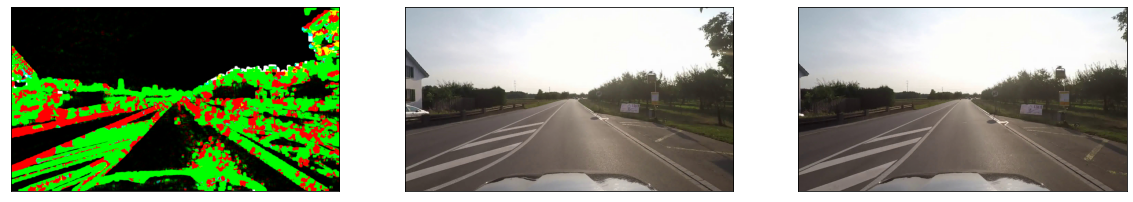

In [42]:
import matplotlib.image as mpimg
img1 = mpimg.imread(test_data.iloc[1636]['image_path'])
img2 = mpimg.imread(test_data.iloc[1637]['image_path'])

for i in range(10):
    rgb_diff = opticalFlowDense(img1,img2)
    if (np.average(rgb_diff) != 0):
        break

plt.figure(1, figsize=(20,10))

plt.subplot(2,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(rgb_diff)
plt.savefig('optflow.jpg')

plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(img1)

plt.subplot(2,3,3)
plt.xticks([])
plt.yticks([])
plt.imshow(img2)